# Improving the Ocean Surface Boundary Layer Mixing Shape Function


### Goals
Our team explores whether the accuracy of the Sane et al. shape function that predicts vertical ocean diffusivity can be improved by either splitting the data and running multiple neural networks either based on physical ocean characteristics or clustering, or by adding additional physically informed variables to the training. The Sane et al. paper trains one neural network on physics informed modeled ocean parameters, including Ocean depth, Coriolis, surface friction velocity, and surface buoyancy flux. Although the shape function described in the Sane et al. paper improves upon the non-physics informed parameterizations in prior global climate models, error still exists. In particular, the network derived shape function exhibits poor performance in representing mixing at nodes that have multi-modal structures (nodes 10-12).

### Explorations (in progress)
1.	Adding new variables (latitude & heat flux & wind stress) to the neural networks
2.  Splitting data based on latitude, heat flux, and wind stress
3. Splitting data based on k-means clustering
4. Splitting data based on other clustering

### Conclusions
1. Adding lat, heat flux & wind stress collectively to model improves performance
2. Adding lat, heat flux & wind stress individually does not improve model performance
3. Training on subsets of latitude, heat flux, and wind stress had mixed results:
       splitting based on wind stress increased performance
       splitting based on latitude resulted in mixed results
       splitting based on heat flux worsened model
4. Splitting by combination of latitude & wind stress led to mixed results

##### Setup workspace and Import packages

In [1]:
%%capture
import importlib

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import matplotlib as mpl
import netCDF4 as ncd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch import nn, optim
import matplotlib.cm as cm
import copy as copy
import multiprocessing as mp
from scipy import stats
import time as time
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import xarray as xr
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
import lib.func_file as ff
import lib.var_func_file as vff
from lib.visual_figure4 import performance_sigma_point
from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores

np.random.seed(100)

cwd_data = cwd + '/data/'
## 
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /home/jovyan/Ocean_mixing_ML_proj/Project2-Parameterization


## Exploration 1: adding new variables to train the neural networks
The shape function defined in the Sane et al. paper only trains on physics informed Ocean depth, Coriolis, surface friction velocity, and surface buoyancy flux data. That said, other variables influence ocean mixing. 

Ocean mixing differs significantly by latitude, season and wind conditions, with greater mixing generally in polar than tropical region, in winter than summer seasons, and in more windy areas. As such, we first explore whether the diffusivity by boundary layer shape function performance improves after the introduction of 1. latitude 2. heat flux 3. wind stress, and 4. all 3 variables added.

Analysis:
1. First analyze latitude, heat flux, and wind stress, understanding the shape and spread of the variables, as well as how the existing model variables differ over different levels of latitude, heat and wind. 
2. Add heat flux, latitude, and wind individually and collectively into the neural networks
3. Analyze performance of neural networks relative 

In [3]:
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/raw_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

h=d['h'][:]
h_ind1=np.where(h>10)[0]
h_ind2=np.where(h<700)[0]
h_ind=np.intersect1d(h_ind1,h_ind2)
sf1=d['SF'][h_ind,:]
sf1=sf1[237945:237945+5000,:] # randomly selected few profiles.

sf=np.zeros([len(sf1),16])

sf1 = sf1.values if hasattr(sf1, "values") else sf1
sf = sf1 / np.max(sf1, axis=1, keepdims=True)

In [4]:
# Open the dataset from Sane et al. 2023, here stored on the cloud, accessible on LEAP-Pangeo
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# this function calculates the coriolis parameter from input latitude 
# 2*Omega*sin(lat), where Omega is the Earth's rotation in 1/s
def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 


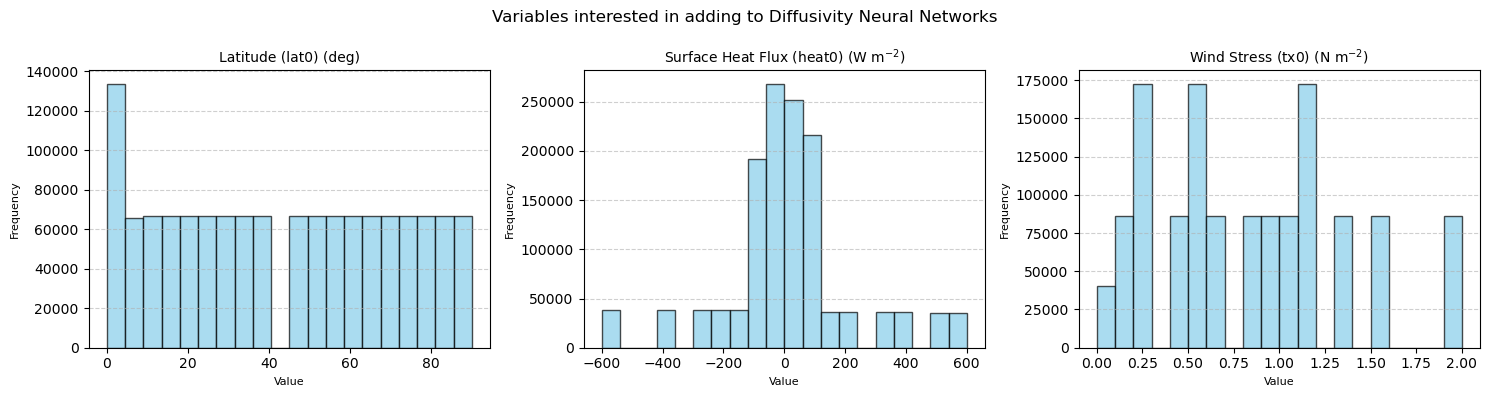

In [5]:
variables = {
    "Latitude (lat0) (deg)": lat0.values.flatten(),
    "Surface Heat Flux (heat0) (W m$^{-2}$)": heat0.values.flatten(),
    "Wind Stress (tx0) (N m$^{-2}$)": tx0.values.flatten(),
}

# Plot histograms for the input variables
plt.figure(figsize=(15, 4))
for i, (name, data) in enumerate(variables.items()):
    plt.subplot(1, 3, i + 1)
    plt.hist(data, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title(name, fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.suptitle("Variables interested in adding to Diffusivity Neural Networks")
plt.tight_layout()
plt.show()

### 1.A Look at how Neural Network variables differ across various levels of latitude and heat, and wind

- latitude: polar (latitude >= 66.5), midlat (latitude btwn 23.4 & 66.5), and tropical (latitude <=23.4)
- heat: high abs(>=150) low abs(<150) and by negative and positive
- wind: low (<1) and high (>=1)

#### findings
- Surface buoyancy is similar across different latitude, heat and wind groupings
- Coriolis decreases the closer to the equator
- Surface fiction doesn't differ by latitude and heat flux; Surface friction is higher for higher winds
- Boundary layer is greater for tropics than mid-lat & polar. Boundary layer is a function of u*/coriolis. Therefore, as coriolis approaches 0 at the equator, this boundary number increases. 

In [6]:
d_polar = d.where(d.lat >= 66.5)
d_midlat = d.where((d.lat < 66.5) & (d.lat>23.4))
d_tropic = d.where(d.lat <= 23.4)

d_hp = d.where(d.heat >= 150)
d_lp = d.where((d.heat < 150) & (d.heat>0))
d_hn = d.where(d.heat <= -150)
d_ln = d.where((d.heat > -150) & (d.heat<0))

d_lw = d.where(d.tx < 1)
d_hw = d.where(d.tx >= 1)

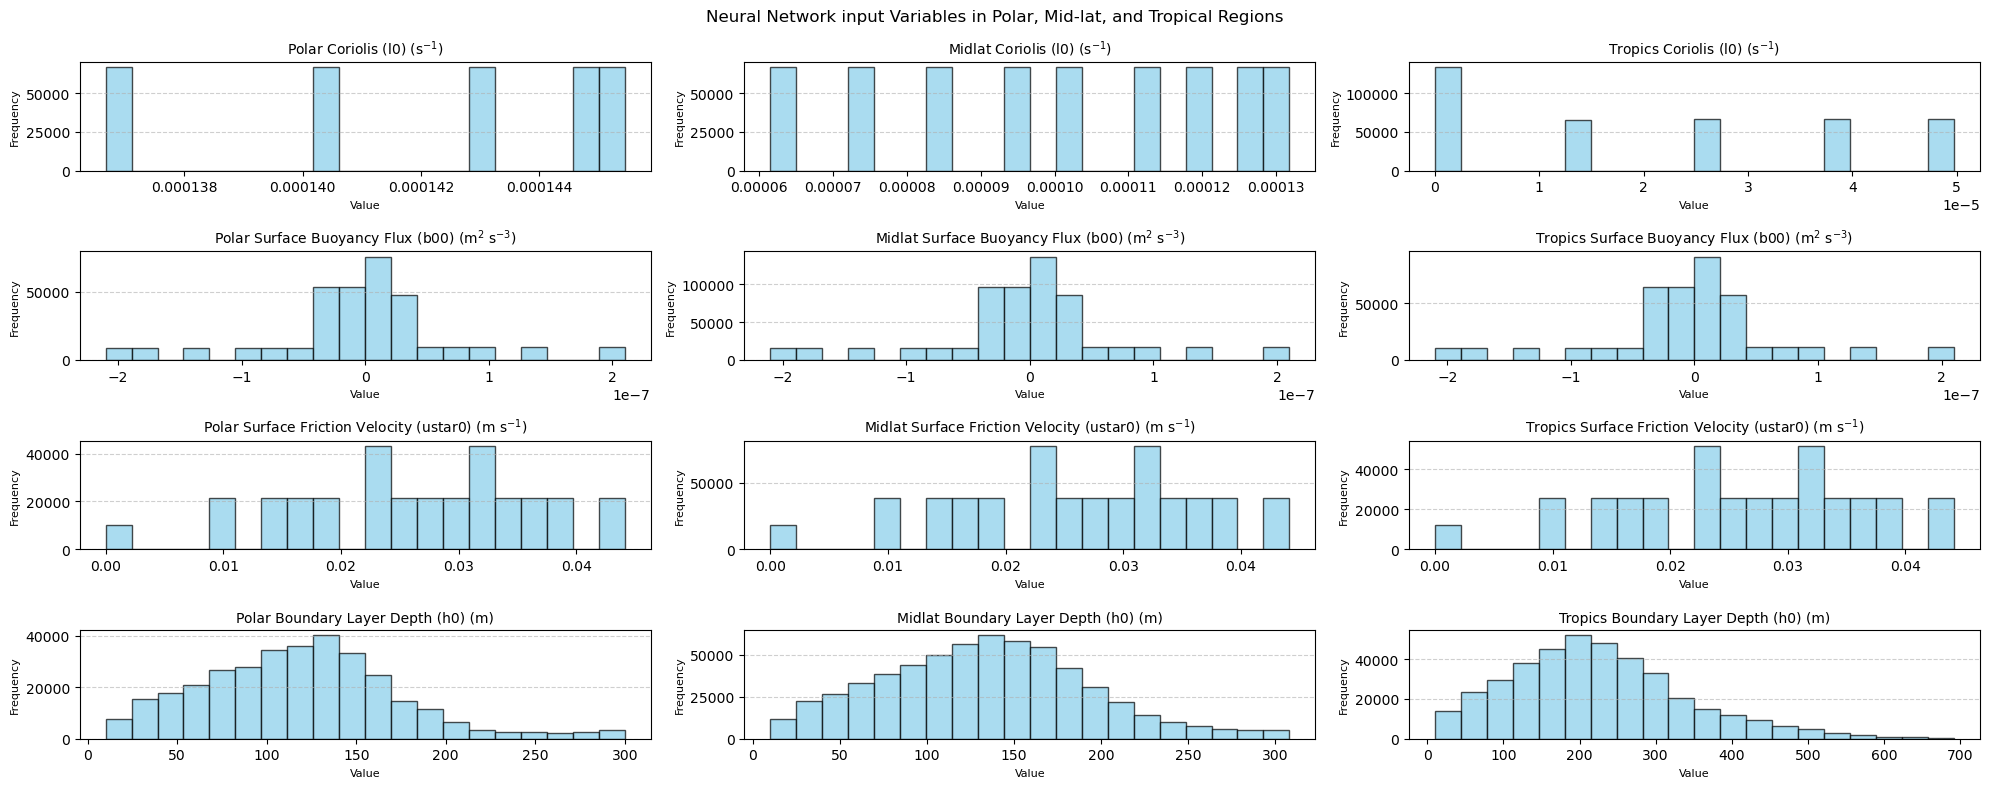

In [7]:
variables_latitude = { 
    "Polar Coriolis (l0) (s$^{-1}$)": corio(d_polar['l'][:]).values.flatten(),
    "Midlat Coriolis (l0) (s$^{-1}$)": corio(d_midlat['l'][:]).values.flatten(),
    "Tropics Coriolis (l0) (s$^{-1}$)": corio(d_tropic['l'][:]).values.flatten(),
    "Polar Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_polar['b0'][:].values.flatten(),
    "Midlat Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_midlat['b0'][:].values.flatten(),
    "Tropics Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_tropic['b0'][:].values.flatten(),
    "Polar Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_polar['ustar'][:].values.flatten(),
    "Midlat Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_midlat['ustar'][:].values.flatten(),
    "Tropics Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_tropic['ustar'][:].values.flatten(),
    "Polar Boundary Layer Depth (h0) (m)": d_polar['h'][:].values.flatten(),
    "Midlat Boundary Layer Depth (h0) (m)": d_midlat['h'][:].values.flatten(),
    "Tropics Boundary Layer Depth (h0) (m)": d_tropic['h'][:].values.flatten(),
}

# Plot histograms for the input variables
plt.figure(figsize=(20, 8))
for i, (name, data) in enumerate(variables_latitude.items()):
    plt.subplot(4, 3, i + 1)
    plt.hist(data, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title(name, fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.suptitle("Neural Network input Variables in Polar, Mid-lat, and Tropical Regions")
plt.tight_layout()
plt.show()

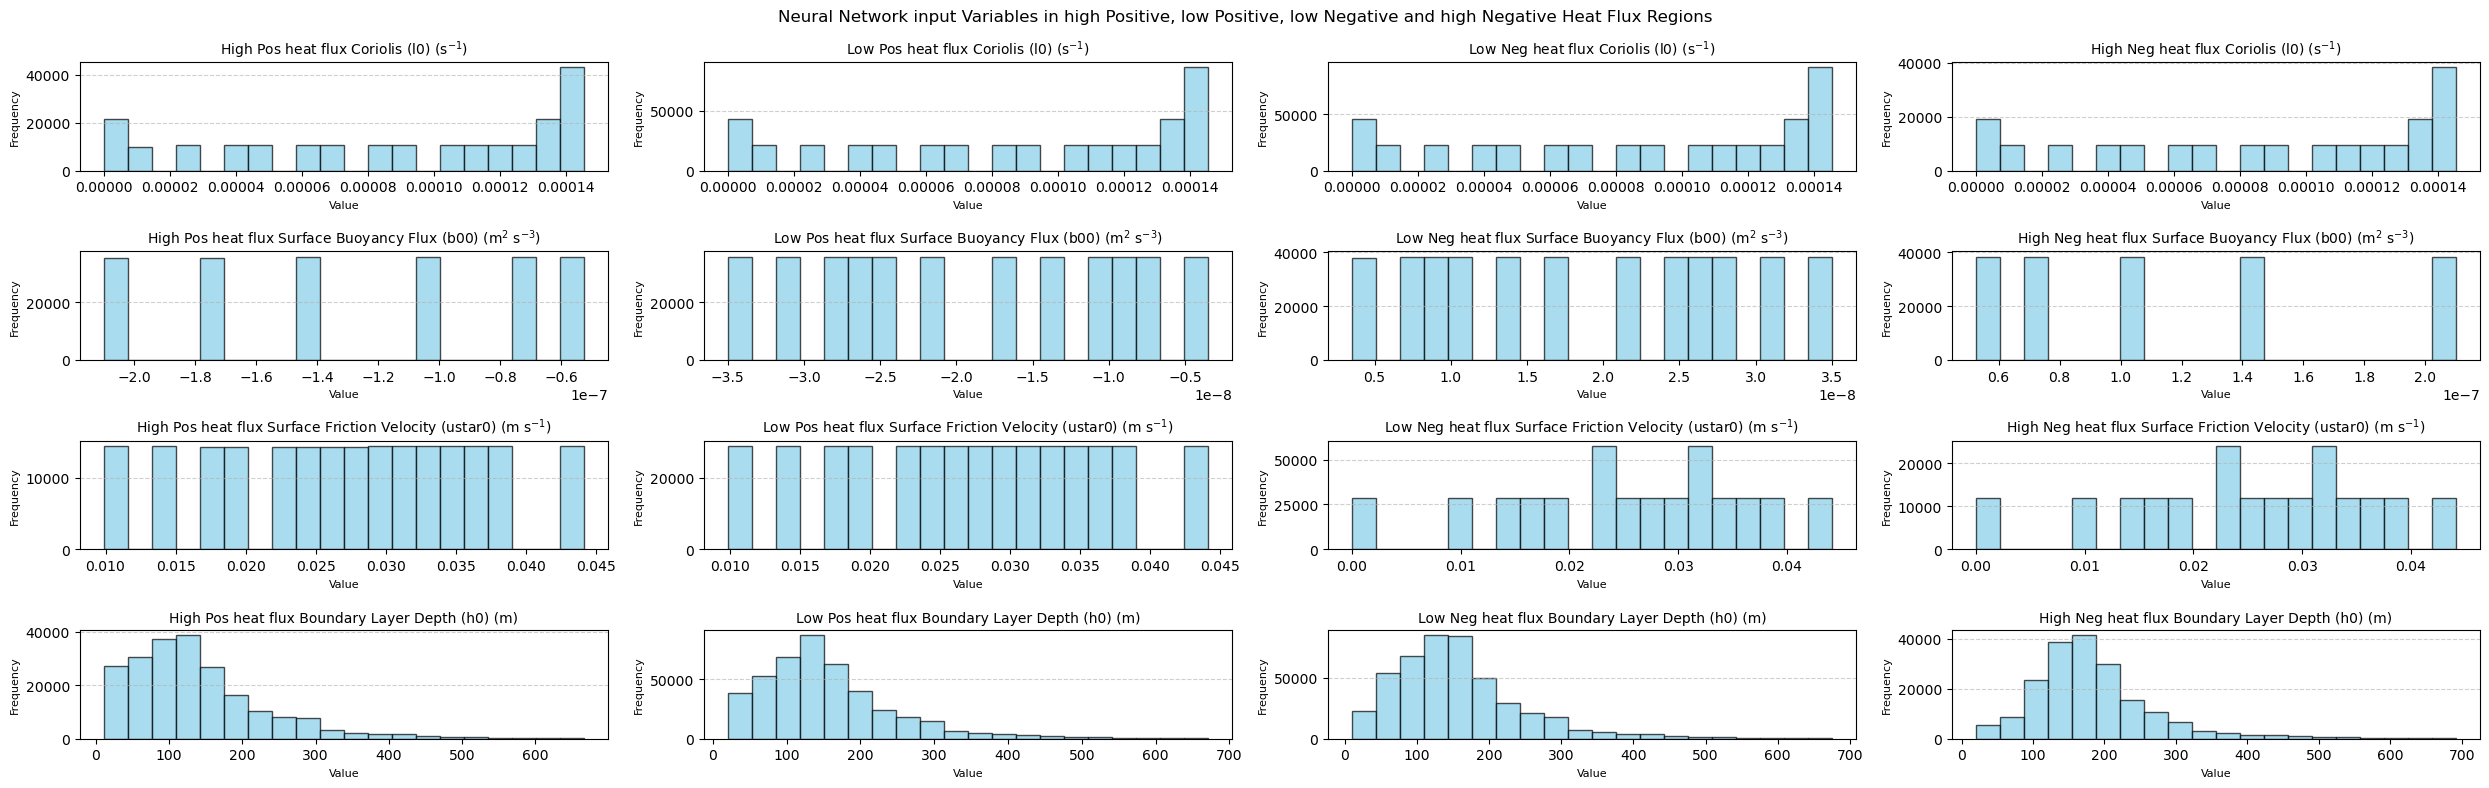

In [8]:
variables_heat_flux = { 
    "High Pos heat flux Coriolis (l0) (s$^{-1}$)": corio(d_hp['l'][:]).values.flatten(),
    "Low Pos heat flux Coriolis (l0) (s$^{-1}$)": corio(d_lp['l'][:]).values.flatten(),
    "Low Neg heat flux Coriolis (l0) (s$^{-1}$)": corio(d_ln['l'][:]).values.flatten(),
    "High Neg heat flux Coriolis (l0) (s$^{-1}$)": corio(d_hn['l'][:]).values.flatten(),
    "High Pos heat flux Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_hp['b0'][:].values.flatten(),
    "Low Pos heat flux Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_lp['b0'][:].values.flatten(),
    "Low Neg heat flux Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_ln['b0'][:].values.flatten(),
    "High Neg heat flux Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_hn['b0'][:].values.flatten(),
    "High Pos heat flux Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_hp['ustar'][:].values.flatten(),
    "Low Pos heat flux Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_lp['ustar'][:].values.flatten(),
    "Low Neg heat flux Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_ln['ustar'][:].values.flatten(),
    "High Neg heat flux Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_hn['ustar'][:].values.flatten(),
    "High Pos heat flux Boundary Layer Depth (h0) (m)": d_hp['h'][:].values.flatten(),
    "Low Pos heat flux Boundary Layer Depth (h0) (m)": d_lp['h'][:].values.flatten(),
    "Low Neg heat flux Boundary Layer Depth (h0) (m)": d_ln['h'][:].values.flatten(),
    "High Neg heat flux Boundary Layer Depth (h0) (m)": d_hn['h'][:].values.flatten(),
}

# Plot histograms for the input variables
plt.figure(figsize=(25, 8))
for i, (name, data) in enumerate(variables_heat_flux.items()):
    plt.subplot(4, 4, i + 1)
    plt.hist(data, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title(name, fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.suptitle("Neural Network input Variables in high Positive, low Positive, low Negative and high Negative Heat Flux Regions")
plt.tight_layout()
plt.show()

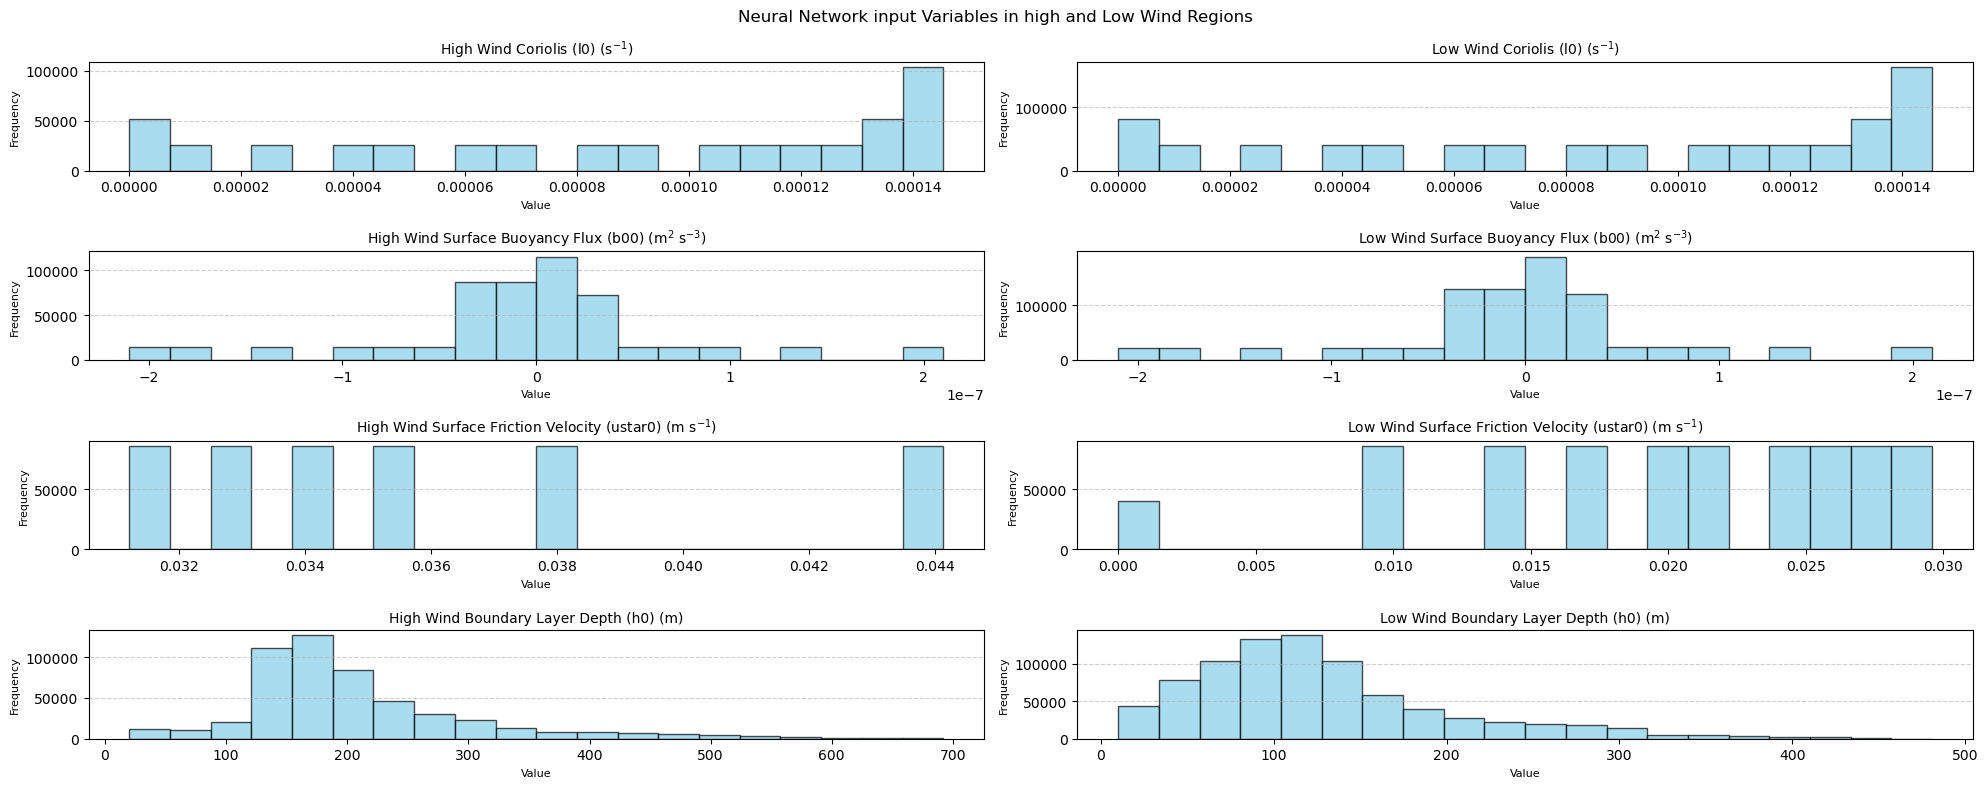

In [9]:
variables_wind = { 
    "High Wind Coriolis (l0) (s$^{-1}$)": corio(d_hw['l'][:]).values.flatten(),
    "Low Wind Coriolis (l0) (s$^{-1}$)": corio(d_lw['l'][:]).values.flatten(),
    "High Wind Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_hw['b0'][:].values.flatten(),
    "Low Wind Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_lw['b0'][:].values.flatten(),
    "High Wind Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_hw['ustar'][:].values.flatten(),
    "Low Wind Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_lw['ustar'][:].values.flatten(),
    "High Wind Boundary Layer Depth (h0) (m)": d_hw['h'][:].values.flatten(),
    "Low Wind Boundary Layer Depth (h0) (m)": d_lw['h'][:].values.flatten(),
}

# Plot histograms for the input variables
plt.figure(figsize=(20, 8))
for i, (name, data) in enumerate(variables_wind.items()):
    plt.subplot(4, 2, i + 1)
    plt.hist(data, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title(name, fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.suptitle("Neural Network input Variables in high and Low Wind Regions")
plt.tight_layout()
plt.show()

In [10]:
def validation_new(x, y):
    x, x_test, y, y_test = train_test_split(x, y, test_size=0.2)
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    x_test=torch.FloatTensor(x_test).to(device)
    y_test=torch.FloatTensor(y_test).to(device)

    return x, x_test, y, y_test
    

In [11]:
def validate_data(x,y):
    url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
    df = pd.read_csv(url, delim_whitespace=True, header = None)  
    valid_data = df.iloc[:, 3:].values 

    ind3=np.where(valid_data[:,3]>29)[0]
    ind4=np.where(valid_data[:,3]<301)[0]
    ind=np.intersect1d(ind3,ind4)

    valid_x=valid_data[ind,0:4]

    valid_x[:,0]=(valid_x[:,0]-stats[0])/stats[1]
    valid_x[:,1]=(valid_x[:,1]-stats[2])/stats[3]
    valid_x[:,2]=(valid_x[:,2]-stats[4])/stats[5]
    valid_x[:,3]=(valid_x[:,3]-stats[6])/stats[7]
    k_mean_test=np.zeros(16)
    valid_y=valid_data[ind,5:]

    for i in range(len(valid_y)):
        valid_y[i,:]=np.log(valid_y[i,:]/np.max(valid_y[i,:]))

    for i in range(16):
        valid_y[:,i]=(valid_y[:,i]-k_mean[i])/k_std[i]

    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    valid_x=torch.FloatTensor(valid_x).to(device)
    valid_y=torch.FloatTensor(valid_y).to(device)

    return x, valid_x, y, valid_y

### 1.2 add heat flux, wind stress, and latitude individually & then collectively as inputs in the Model

#### Findings
- Adding all of the variables to the neural networks reduces shape function error
- Individually adding heat flux & latitude increases shape function error
- Individually adding wind stress increases/decreases SF error, depending node; introducing wind stress reduces performance in nodes that have multi-modal structures (nodes 10-12). 


In [12]:
data, x, y, stats, k_mean, k_std  = vff.train_model(d, 'paper')
data_l, x_l, y_l, stats_l, k_mean_l, k_std_l  = vff.train_model(d, 'lat')
data_h, x_h, y_h, stats_h, k_mean_h, k_std_h  = vff.train_model(d, 'heat')
data_w, x_w, y_w, stats_w, k_mean_w, k_std_w  = vff.train_model(d, 'wind')
data_a, x_a, y_a, stats_a, k_mean_a, k_std_a  = vff.train_model(d, 'all')

started paper model
started model with latitude
started model with heat
started model with wind
started all data


In [13]:
x, valid_x, y, valid_y = validate_data(x, y)
x_l, x_test_l, y_l, y_test_l = validation_new(x_l, y_l)
x_h, x_test_h, y_h, y_test_h = validation_new(x_h, y_h)
x_w, x_test_w, y_w, y_test_w = validation_new(x_w, y_w)
x_a, x_test_a, y_a, y_test_a = validation_new(x_a, y_a)

In [14]:
# Loss weighting option here, all weights = 1.0 in default run 
# Weight settings here
kms1=1.0 
kms2=1.0
# Weight per node set here. Set weights to kms1 or to kms2 to use values above
k16 = kms1; k15 = kms1; k14 = kms1; k13 = kms1; k12 = kms1; k11 = kms1; 
k10 = kms1; k9 = kms1; k8 = kms1; k7 = kms1; k6 = kms1; k5 = kms1; 
k4 = kms1; k3 = kms1; k2 = kms1; k1 = kms1; 
# Weight for each layer. 
# ARRANGED FROM TOP (node = 16) TO BOTTOM (node = 1)
kmask=np.array([k16,k15,k14,k13,k12,k11,k10,k9,k8,k7,k6,k5,k4,k3,k2,k1])

In [15]:
# Run model in paper
epochs, k_points, lr=3000, 16, 1e-03
in_nod, hid_nod, o_nod = 4, 32, 16

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

model = vff.learnKappa_layers(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y,valid_x,valid_y,model,torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

#Run model with latitude
epochs, k_points, lr=3000, 16, 1e-03
in_nod2, hid_nod2, o_nod2 = 5, 32, 16
model2 = vff.learnKappa_layers(in_nod2, hid_nod2, o_nod2)
model2 = model2.to(device)

k_mean_lc=torch.tensor(k_mean_l).float().to(device)
k_std_lc=torch.tensor(k_std_l).float().to(device)

model_l, loss_array_l = vff.modeltrain_loss(in_nod2, hid_nod2, o_nod2, lr, epochs, x_l, y_l,x_test_l,y_test_l,model2,torch.tensor(kmask).float().to(device), k_mean_lc, k_std_lc)

#Run model with heat flux
k_mean_hc=torch.tensor(k_mean_h).float().to(device)
k_std_hc=torch.tensor(k_std_h).float().to(device)

model_h, loss_array_h = vff.modeltrain_loss(in_nod2, hid_nod2, o_nod2, lr, epochs, x_h, y_h,x_test_h,y_test_h,model2,torch.tensor(kmask).float().to(device), k_mean_hc, k_std_hc)

#Run model with wind stress
k_mean_wc=torch.tensor(k_mean_w).float().to(device)
k_std_wc=torch.tensor(k_std_w).float().to(device)

model_w, loss_array_w = vff.modeltrain_loss(in_nod2, hid_nod2, o_nod2, lr, epochs, x_w, y_w,x_test_w,y_test_w,model2,torch.tensor(kmask).float().to(device), k_mean_wc, k_std_wc)

#run model with all data added
epochs, k_points, lr=3000, 16, 1e-03
in_nod3, hid_nod3, o_nod3 = 7, 32, 16
model3 = vff.learnKappa_layers(in_nod3, hid_nod3, o_nod3)
model3 = model3.to(device)

k_mean_ac=torch.tensor(k_mean_a).float().to(device)
k_std_ac=torch.tensor(k_std_a).float().to(device)

model_a, loss_array_a = vff.modeltrain_loss(in_nod3, hid_nod3, o_nod3, lr, epochs, x_a, y_a,x_test_a,y_test_a,model3,torch.tensor(kmask).float().to(device), k_mean_ac, k_std_ac)

Training Progress:  26%|██▌       | 767/3000 [00:25<01:15, 29.54epoch/s, patience_count=19, train_loss=0.0387, valid_loss=0.0557]



Early stopping at epoch 767. Validation loss has not improved for 20 epochs.


Training Progress:  33%|███▎      | 979/3000 [00:28<00:58, 34.30epoch/s, patience_count=19, train_loss=0.0591, valid_loss=0.0593]



Early stopping at epoch 979. Validation loss has not improved for 20 epochs.


Training Progress:  49%|████▉     | 1471/3000 [00:43<00:45, 33.71epoch/s, patience_count=19, train_loss=0.0446, valid_loss=0.0447]



Early stopping at epoch 1471. Validation loss has not improved for 20 epochs.


Training Progress:  22%|██▏       | 648/3000 [00:19<01:09, 33.75epoch/s, patience_count=19, train_loss=0.0486, valid_loss=0.0488]



Early stopping at epoch 648. Validation loss has not improved for 20 epochs.


Training Progress:  42%|████▏     | 1255/3000 [00:37<00:51, 33.87epoch/s, patience_count=19, train_loss=0.0358, valid_loss=0.0359]


Early stopping at epoch 1255. Validation loss has not improved for 20 epochs.


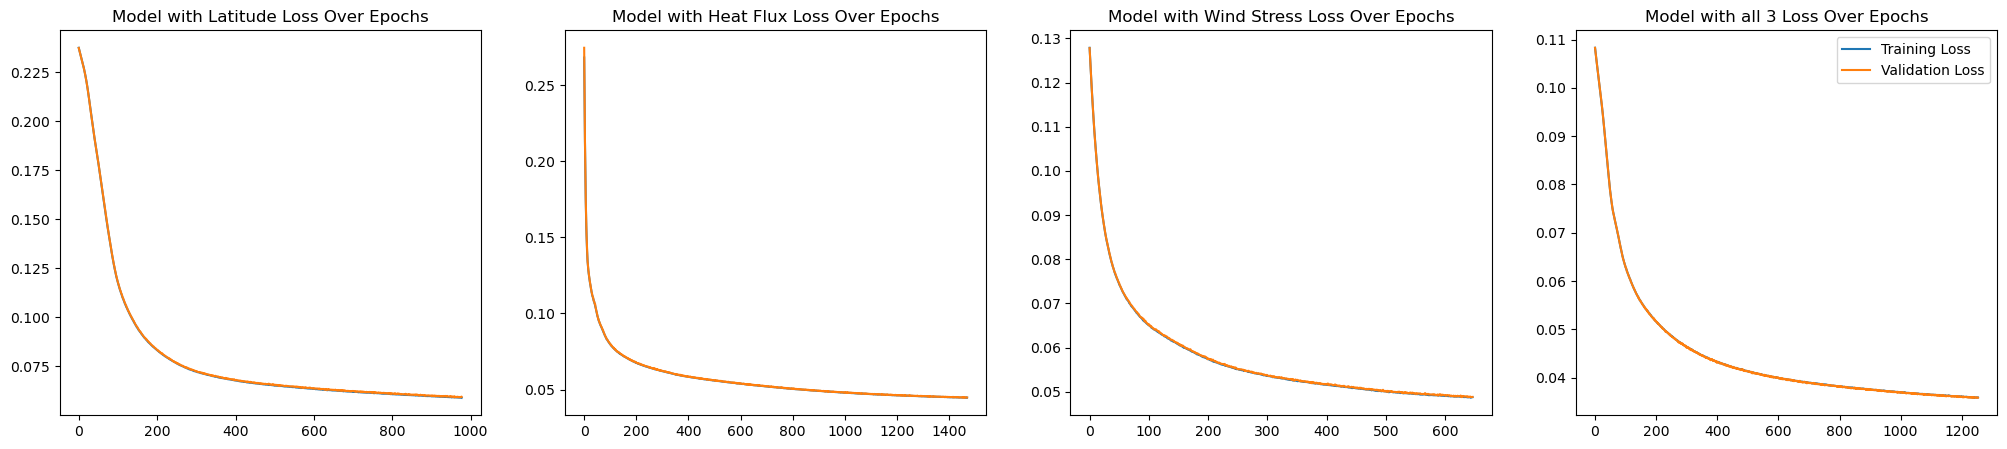

In [16]:
fig, axes = plt.subplots(figsize=(25, 5), ncols = 4)
axes[0].plot(loss_array_l[:, 0], loss_array_l[:, 1], label="Training Loss")
axes[0].plot(loss_array_l[:, 0], loss_array_l[:, 2], label="Validation Loss")
axes[0].set_title("Model with Latitude Loss Over Epochs")
axes[1].plot(loss_array_h[:, 0], loss_array_h[:, 1], label="Training Loss")
axes[1].plot(loss_array_h[:, 0], loss_array_h[:, 2], label="Validation Loss")
axes[1].set_title("Model with Heat Flux Loss Over Epochs")
axes[2].plot(loss_array_w[:, 0], loss_array_w[:, 1], label="Training Loss")
axes[2].plot(loss_array_w[:, 0], loss_array_w[:, 2], label="Validation Loss")
axes[2].set_title("Model with Wind Stress Loss Over Epochs")
axes[3].plot(loss_array_a[:, 0], loss_array_a[:, 1], label="Training Loss")
axes[3].plot(loss_array_a[:, 0], loss_array_a[:, 2], label="Validation Loss")
axes[3].set_title("Model with all 3 Loss Over Epochs")
plt.legend()
plt.savefig('Training_Validation_loss_new_var.png')
plt.show()

In [16]:
yerr, kappa_mean, ytestcpu, yptestcpu = vff.return_model_error(model, x, valid_x, y_l, valid_y, k_mean, k_std)
yerr_l, kappa_mean_l, ytestcpu_l, yptestcpu_l = vff.return_model_error(model_l, x_l, x_test_l, y_l, y_test_l, k_mean_l, k_std_l)
yerr_h, kappa_mean_h, ytestcpu_h, yptestcpu_h = vff.return_model_error(model_h, x_h, x_test_h, y_h, y_test_h, k_mean_h, k_std_h)
yerr_w, kappa_mean_w, ytestcpu_w, yptestcpu_w = vff.return_model_error(model_w, x_w, x_test_w, y_w, y_test_w, k_mean_w, k_std_w)
yerr_a, kappa_mean_a, ytestcpu_a, yptestcpu_a = vff.return_model_error(model_a, x_a, x_test_a, y_a, y_test_a, k_mean_a, k_std_a)

In [17]:
error_comp_l = ((yerr_l - yerr)/yerr)*100
error_comp_h = ((yerr_h - yerr)/yerr)*100
error_comp_w = ((yerr_w - yerr)/yerr)*100
error_comp_a = ((yerr_a - yerr)/yerr)*100

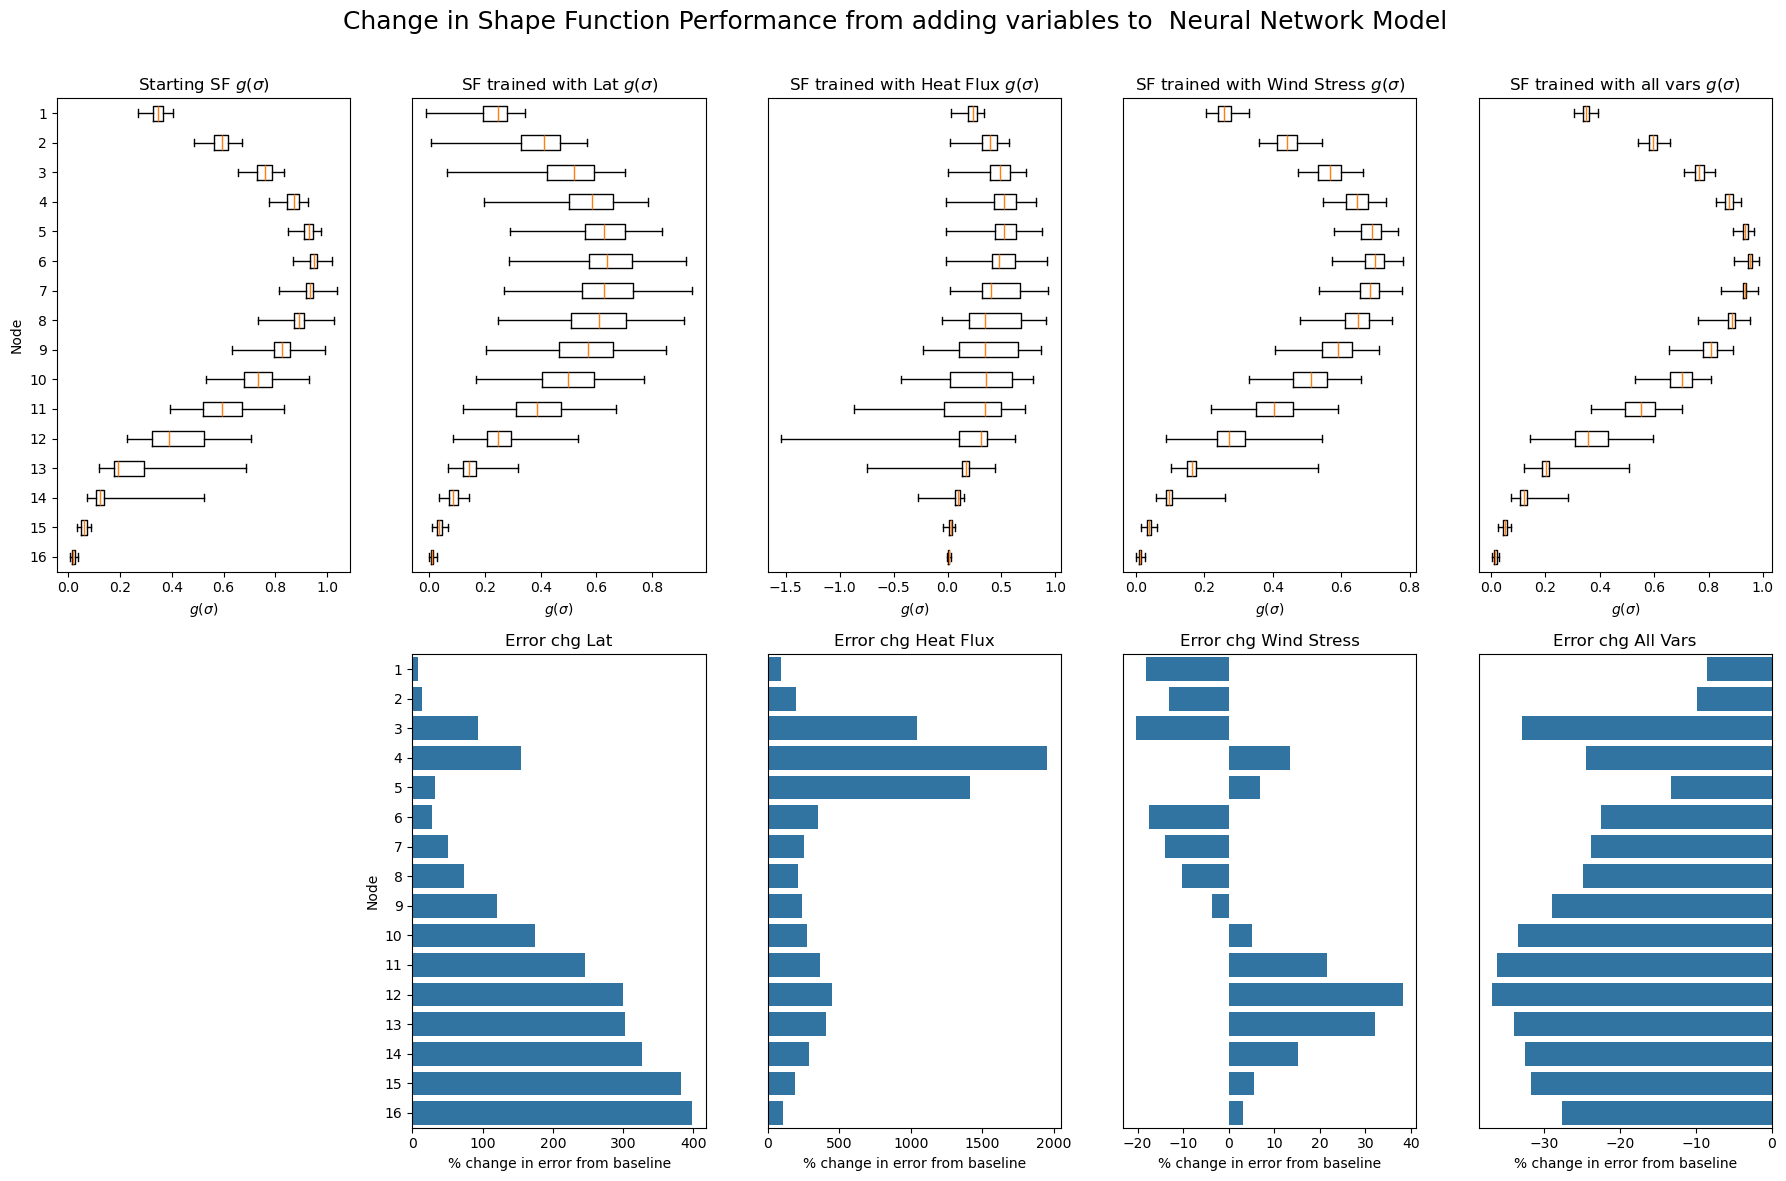

In [75]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 5, 1)
for i in range(16):
    plt.boxplot(kappa_mean[i] + np.exp(ytestcpu[:, i] * k_std[i] + k_mean[i]) - np.exp(yptestcpu[:, i] * k_std[i] + k_mean[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
#plt.yticks([])
plt.yticks(ind, ind_tick)
plt.ylabel('Node')
plt.title(r'Starting SF $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 5, 2)
for i in range(16):
    plt.boxplot(kappa_mean_l[i] + np.exp(ytestcpu_l[:, i] * k_std_l[i] + k_mean_l[i]) - np.exp(yptestcpu_l[:, i] * k_std_l[i] + k_mean_l[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained with Lat $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 5, 3)
for i in range(16):
    plt.boxplot(kappa_mean_h[i] + np.exp(ytestcpu_h[:, i] * k_std_h[i] + k_mean_h[i]) - np.exp(yptestcpu_h[:, i] * k_std_h[i] + k_mean_h[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained with Heat Flux $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 5, 4)
for i in range(16):
    plt.boxplot(kappa_mean_w[i] + np.exp(ytestcpu_w[:, i] * k_std_w[i] + k_mean_w[i]) - np.exp(yptestcpu_w[:, i] * k_std_w[i] + k_mean_w[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained with Wind Stress $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 5, 5)
for i in range(16):
    plt.boxplot(kappa_mean_a[i] + np.exp(ytestcpu_a[:, i] * k_std_a[i] + k_mean_a[i]) - np.exp(yptestcpu_a[:, i] * k_std_a[i] + k_mean_a[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained with all vars $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 5, 7)
sns.barplot(x=error_comp_l, y=np.arange(len(error_comp_l))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.ylabel('Node')
plt.title('Error chg Lat')

plt.subplot(2, 5, 8)
sns.barplot(x=error_comp_h, y=np.arange(len(error_comp_h))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg Heat Flux')

plt.subplot(2, 5, 9)
sns.barplot(x=error_comp_w, y=np.arange(len(error_comp_w))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg Wind Stress')

plt.subplot(2, 5, 10)
sns.barplot(x=error_comp_a, y=np.arange(len(error_comp_a))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg All Vars')

plt.suptitle('Change in Shape Function Performance from adding variables to  Neural Network Model',fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### 2.1 Splitting data based on parameters prior to running Neural Network

#### Findings
- Adding all of the variables to the neural networks reduces shape function error
- Individually adding heat flux & latitude increases shape function error
- Individually adding wind stress increases/decreases SF error, depending node; introducing wind stress reduces performance in nodes that have multi-modal structures (nodes 10-12). 


In [64]:
data_p, x_p, y_p, stats_p, k_mean_p, k_std_p  = vff.train_model(d_polar, 'paper')
data_m, x_m, y_m, stats_m, k_mean_m, k_std_m  = vff.train_model(d_midlat, 'paper')
data_t, x_t, y_t, stats_t, k_mean_t, k_std_t  = vff.train_model(d_tropic, 'paper')

data_hp, x_hp, y_hp, stats_hp, k_mean_hp, k_std_hp  = vff.train_model(d_hp, 'paper')
data_lp, x_lp, y_lp, stats_lp, k_mean_lp, k_std_lp  = vff.train_model(d_lp, 'paper')
data_ln, x_ln, y_ln, stats_ln, k_mean_ln, k_std_ln  = vff.train_model(d_ln, 'paper')
data_hn, x_hn, y_hn, stats_hn, k_mean_hn, k_std_hn  = vff.train_model(d_hn, 'paper')

data_lw, x_lw, y_lw, stats_lw, k_mean_lw, k_std_lw  = vff.train_model(d_lw, 'paper')
data_hw, x_hw, y_hw, stats_hw, k_mean_hw, k_std_hw  = vff.train_model(d_hw, 'paper')

started paper model
started paper model
started paper model
started paper model
started paper model
started paper model
started paper model
started paper model
started paper model


In [76]:
x_p, x_test_p, y_p, y_test_p = validation_new(x_p, y_p)
x_m, x_test_m, y_m, y_test_m = validation_new(x_m, y_m)
x_t, x_test_t, y_t, y_test_t = validation_new(x_t, y_t)

x_hp, x_test_hp, y_hp, y_test_hp = validation_new(x_hp, y_hp)
x_lp, x_test_lp, y_lp, y_test_lp = validation_new(x_lp, y_lp)
x_ln, x_test_ln, y_ln, y_test_ln = validation_new(x_ln, y_ln)
x_hn, x_test_hn, y_hn, y_test_hn = validation_new(x_hn, y_hn)

x_lw, x_test_lw, y_lw, y_test_lw = validation_new(x_lw, y_lw)
x_hw, x_test_hw, y_hw, y_test_hw = validation_new(x_hw, y_hw)

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

In [77]:
epochs, k_points1, lr1=3000, 12, 1e-04
##LATITUDE
#polar
k_mean_pc=torch.tensor(k_mean_p).float().to(device)
k_std_pc=torch.tensor(k_std_p).float().to(device)

model_p, loss_array_p = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_p, y_p,x_test_p,y_test_p,model,torch.tensor(kmask).float().to(device), k_mean_pc, k_std_pc)
#midlat
k_mean_mc=torch.tensor(k_mean_m).float().to(device)
k_std_mc=torch.tensor(k_std_m).float().to(device)

model_m, loss_array_m = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_m, y_m,x_test_m,y_test_m,model,torch.tensor(kmask).float().to(device), k_mean_mc, k_std_mc)
#tropics
k_mean_tc=torch.tensor(k_mean_t).float().to(device)
k_std_tc=torch.tensor(k_std_t).float().to(device)

model_t, loss_array_t = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_t, y_t,x_test_t,y_test_t,model,torch.tensor(kmask).float().to(device), k_mean_tc, k_std_tc)

k_mean_hpc=torch.tensor(k_mean_hp).float().to(device)
k_std_hpc=torch.tensor(k_std_hp).float().to(device)

model_hp, loss_array_hp = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_hp, y_hp,x_test_hp,y_test_hp,model,torch.tensor(kmask).float().to(device), k_mean_hpc, k_std_hpc)

##HEAT FLUX
#low positive heat flux
k_mean_lpc=torch.tensor(k_mean_lp).float().to(device)
k_std_lpc=torch.tensor(k_std_lp).float().to(device)

model_lp, loss_array_lp = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_lp, y_lp,x_test_lp,y_test_lp,model,torch.tensor(kmask).float().to(device), k_mean_lpc, k_std_lpc)
#low negative heat flux
k_mean_lnc=torch.tensor(k_mean_ln).float().to(device)
k_std_lnc=torch.tensor(k_std_ln).float().to(device)

model_ln, loss_array_ln = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_ln, y_ln,x_test_ln,y_test_ln,model,torch.tensor(kmask).float().to(device), k_mean_lnc, k_std_lnc)
#high negative heat flux
k_mean_hnc=torch.tensor(k_mean_hn).float().to(device)
k_std_hnc=torch.tensor(k_std_hn).float().to(device)

model_hn, loss_array_hn = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_hn, y_hn,x_test_hn,y_test_hn,model,torch.tensor(kmask).float().to(device), k_mean_hnc, k_std_hnc)

##WIND STRESS
#high wind
k_mean_hwc=torch.tensor(k_mean_hw).float().to(device)
k_std_hwc=torch.tensor(k_std_hw).float().to(device)

model_hw, loss_array_hw = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_hw, y_hw,x_test_hw,y_test_hw,model,torch.tensor(kmask).float().to(device), k_mean_hwc, k_std_hwc)
#low wind 
k_mean_lwc=torch.tensor(k_mean_lw).float().to(device)
k_std_lwc=torch.tensor(k_std_lw).float().to(device)

model_lw, loss_array_lw = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_lw, y_lw,x_test_lw,y_test_lw,model,torch.tensor(kmask).float().to(device), k_mean_lwc, k_std_lwc)

Training Progress:  23%|██▎       | 685/3000 [00:05<00:19, 118.89epoch/s, patience_count=19, train_loss=0.0328, valid_loss=0.0326]



Early stopping at epoch 685. Validation loss has not improved for 20 epochs.


Training Progress:  10%|▉         | 288/3000 [00:04<00:38, 69.64epoch/s, patience_count=19, train_loss=0.0306, valid_loss=0.0304]



Early stopping at epoch 288. Validation loss has not improved for 20 epochs.


Training Progress:  28%|██▊       | 853/3000 [00:07<00:19, 112.19epoch/s, patience_count=19, train_loss=0.0561, valid_loss=0.056] 



Early stopping at epoch 853. Validation loss has not improved for 20 epochs.


Training Progress:  40%|███▉      | 1195/3000 [00:06<00:09, 187.09epoch/s, patience_count=19, train_loss=0.0263, valid_loss=0.0263]



Early stopping at epoch 1195. Validation loss has not improved for 20 epochs.


Training Progress:  43%|████▎     | 1292/3000 [00:13<00:17, 96.31epoch/s, patience_count=19, train_loss=0.0261, valid_loss=0.0261]



Early stopping at epoch 1292. Validation loss has not improved for 20 epochs.


Training Progress:  49%|████▉     | 1464/3000 [00:16<00:17, 89.33epoch/s, patience_count=19, train_loss=0.035, valid_loss=0.0351] 



Early stopping at epoch 1464. Validation loss has not improved for 20 epochs.


Training Progress:  22%|██▏       | 671/3000 [00:03<00:12, 186.48epoch/s, patience_count=19, train_loss=0.0492, valid_loss=0.0492]



Early stopping at epoch 671. Validation loss has not improved for 20 epochs.


Training Progress:  21%|██▏       | 644/3000 [00:03<00:13, 168.35epoch/s, patience_count=19, train_loss=0.0294, valid_loss=0.0293]



Early stopping at epoch 644. Validation loss has not improved for 20 epochs.


Training Progress:  34%|███▍      | 1035/3000 [00:25<00:48, 40.44epoch/s, patience_count=19, train_loss=0.0425, valid_loss=0.0423]


Early stopping at epoch 1035. Validation loss has not improved for 20 epochs.


In [79]:
yerr_p, kappa_mean_p, ytestcpu_p, yptestcpu_p = vff.return_model_error(model_p,x_p,x_test_p,y_p,y_test_p,k_mean_p,k_std_p)
yerr_m, kappa_mean_m, ytestcpu_m, yptestcpu_m = vff.return_model_error(model_m,x_m,x_test_m,y_m,y_test_m,k_mean_m,k_std_m)
yerr_t, kappa_mean_t, ytestcpu_t, yptestcpu_t = vff.return_model_error(model_t,x_t,x_test_t,y_t,y_test_t,k_mean_t,k_std_t)

yerr_hp, kappa_mean_hp, ytestcpu_hp, yptestcpu_hp = vff.return_model_error(model_hp,x_hp,x_test_hp,y_hp,y_test_hp,k_mean_hp,k_std_hp)
yerr_lp, kappa_mean_lp, ytestcpu_lp, yptestcpu_lp = vff.return_model_error(model_lp,x_lp,x_test_lp,y_lp,y_test_lp,k_mean_lp,k_std_lp)
yerr_ln, kappa_mean_ln, ytestcpu_ln, yptestcpu_ln = vff.return_model_error(model_ln,x_ln,x_test_ln,y_ln,y_test_ln,k_mean_ln,k_std_ln)
yerr_hn, kappa_mean_hn, ytestcpu_hn, yptestcpu_hn = vff.return_model_error(model_hn,x_hn,x_test_hn,y_hn,y_test_hn,k_mean_hn,k_std_hn)

yerr_hw, kappa_mean_hw, ytestcpu_hw, yptestcpu_hw = vff.return_model_error(model_hw,x_hw,x_test_hw,y_hw,y_test_hw,k_mean_hw,k_std_hw)
yerr_lw, kappa_mean_lw, ytestcpu_lw, yptestcpu_lw = vff.return_model_error(model_lw,x_lw,x_test_lw,y_lw,y_test_lw,k_mean_lw,k_std_lw)

error_comp_p = ((yerr_p - yerr)/yerr)*100
error_comp_m = ((yerr_m - yerr)/yerr)*100
error_comp_t = ((yerr_t - yerr)/yerr)*100

error_comp_hp = ((yerr_hp - yerr)/yerr)*100
error_comp_lp = ((yerr_lp - yerr)/yerr)*100
error_comp_ln = ((yerr_ln - yerr)/yerr)*100
error_comp_hn = ((yerr_hn - yerr)/yerr)*100

error_comp_hw = ((yerr_hw - yerr)/yerr)*100
error_comp_lw = ((yerr_lw - yerr)/yerr)*100

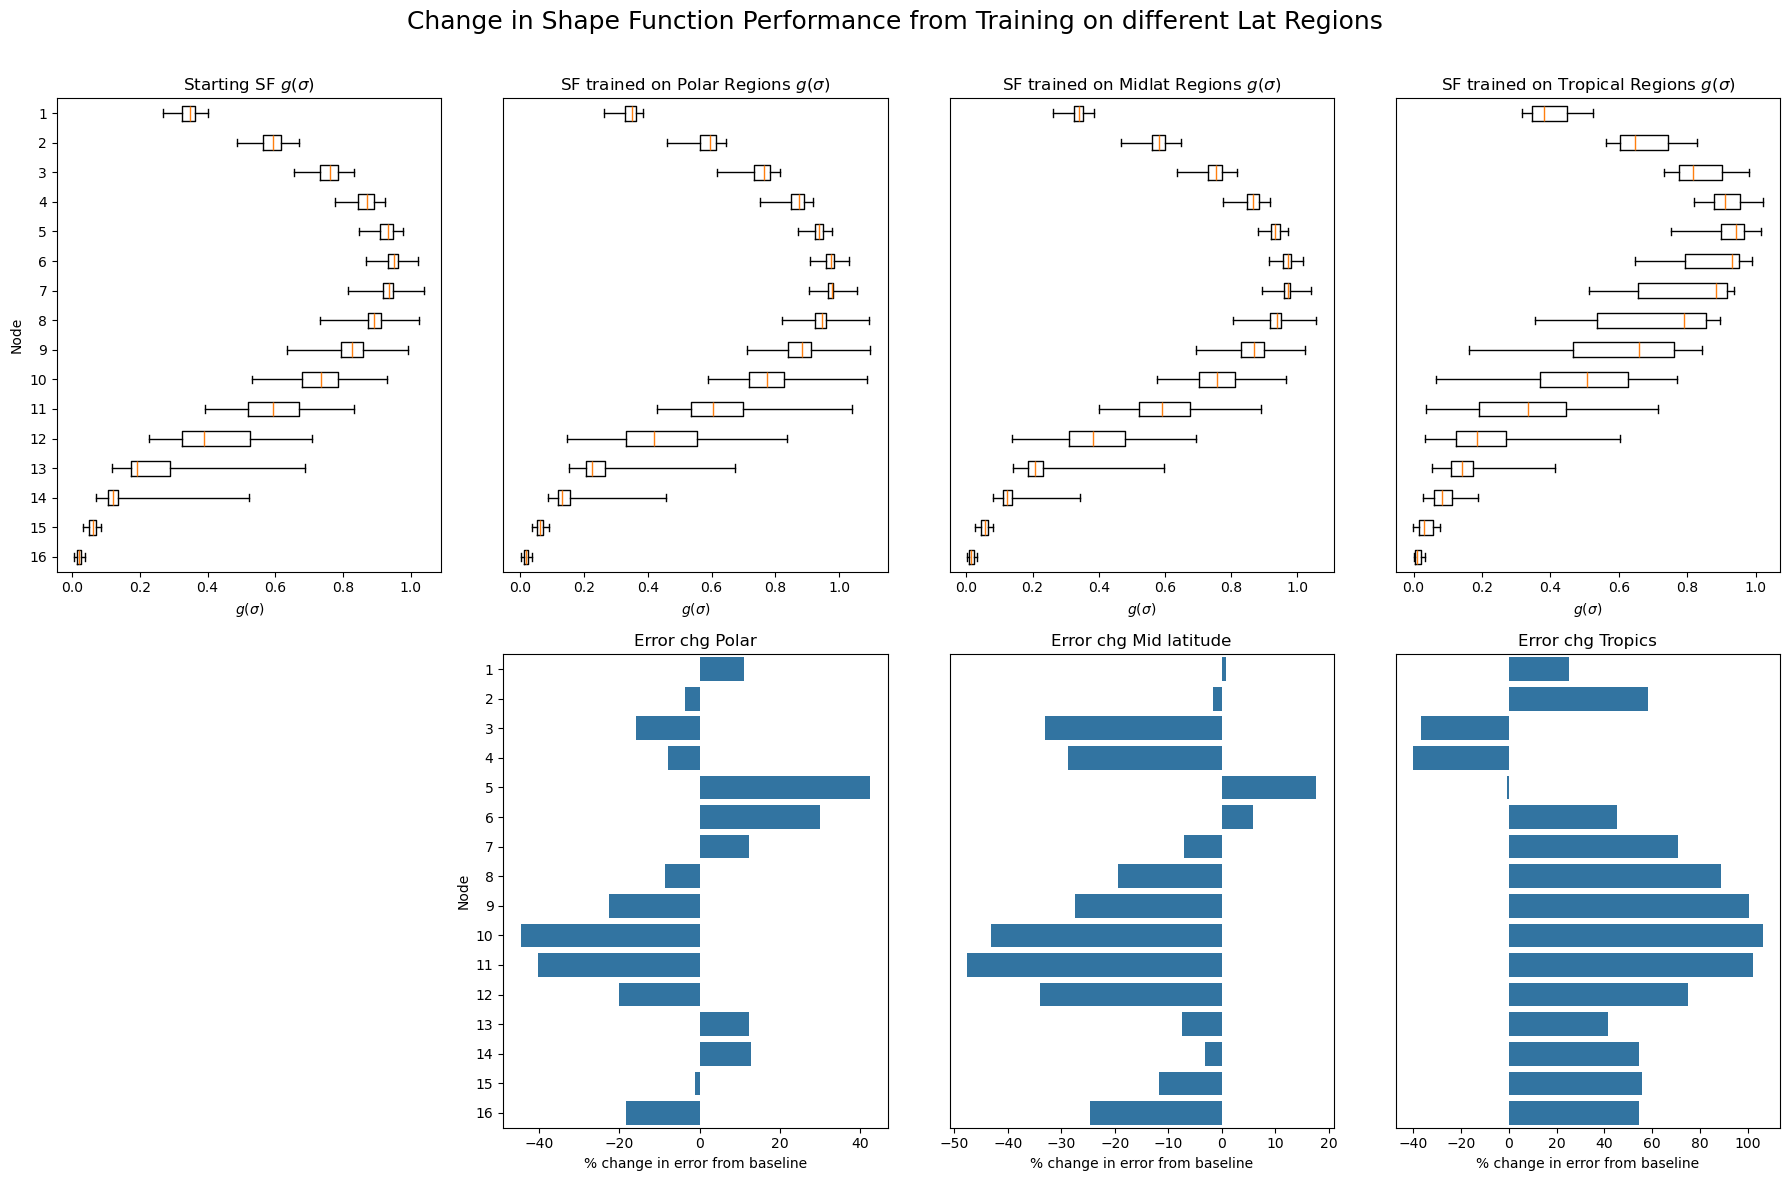

In [81]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 4, 1)
for i in range(16):
    plt.boxplot(kappa_mean[i] + np.exp(ytestcpu[:, i] * k_std[i] + k_mean[i]) - np.exp(yptestcpu[:, i] * k_std[i] + k_mean[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
#plt.yticks([])
plt.yticks(ind, ind_tick)
plt.ylabel('Node')
plt.title(r'Starting SF $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 4, 2)
for i in range(16):
    plt.boxplot(kappa_mean_p[i] + np.exp(ytestcpu_p[:, i] * k_std_p[i] + k_mean_p[i]) - np.exp(yptestcpu_p[:, i] * k_std_p[i] + k_mean_p[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Polar Regions $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 4, 3)
for i in range(16):
    plt.boxplot(kappa_mean_m[i] + np.exp(ytestcpu_m[:, i] * k_std_m[i] + k_mean_m[i]) - np.exp(yptestcpu_m[:, i] * k_std_m[i] + k_mean_m[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Midlat Regions $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 4, 4)
for i in range(16):
    plt.boxplot(kappa_mean_t[i] + np.exp(ytestcpu_t[:, i] * k_std_t[i] + k_mean_t[i]) - np.exp(yptestcpu_t[:, i] * k_std_t[i] + k_mean_t[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Tropical Regions $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 4, 6)
sns.barplot(x=error_comp_p, y=np.arange(len(error_comp_p))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.ylabel('Node')
plt.title('Error chg Polar')

plt.subplot(2, 4, 7)
sns.barplot(x=error_comp_m, y=np.arange(len(error_comp_m))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg Mid latitude')

plt.subplot(2, 4, 8)
sns.barplot(x=error_comp_t, y=np.arange(len(error_comp_t))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg Tropics')

plt.suptitle('Change in Shape Function Performance from Training on different Lat Regions',fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

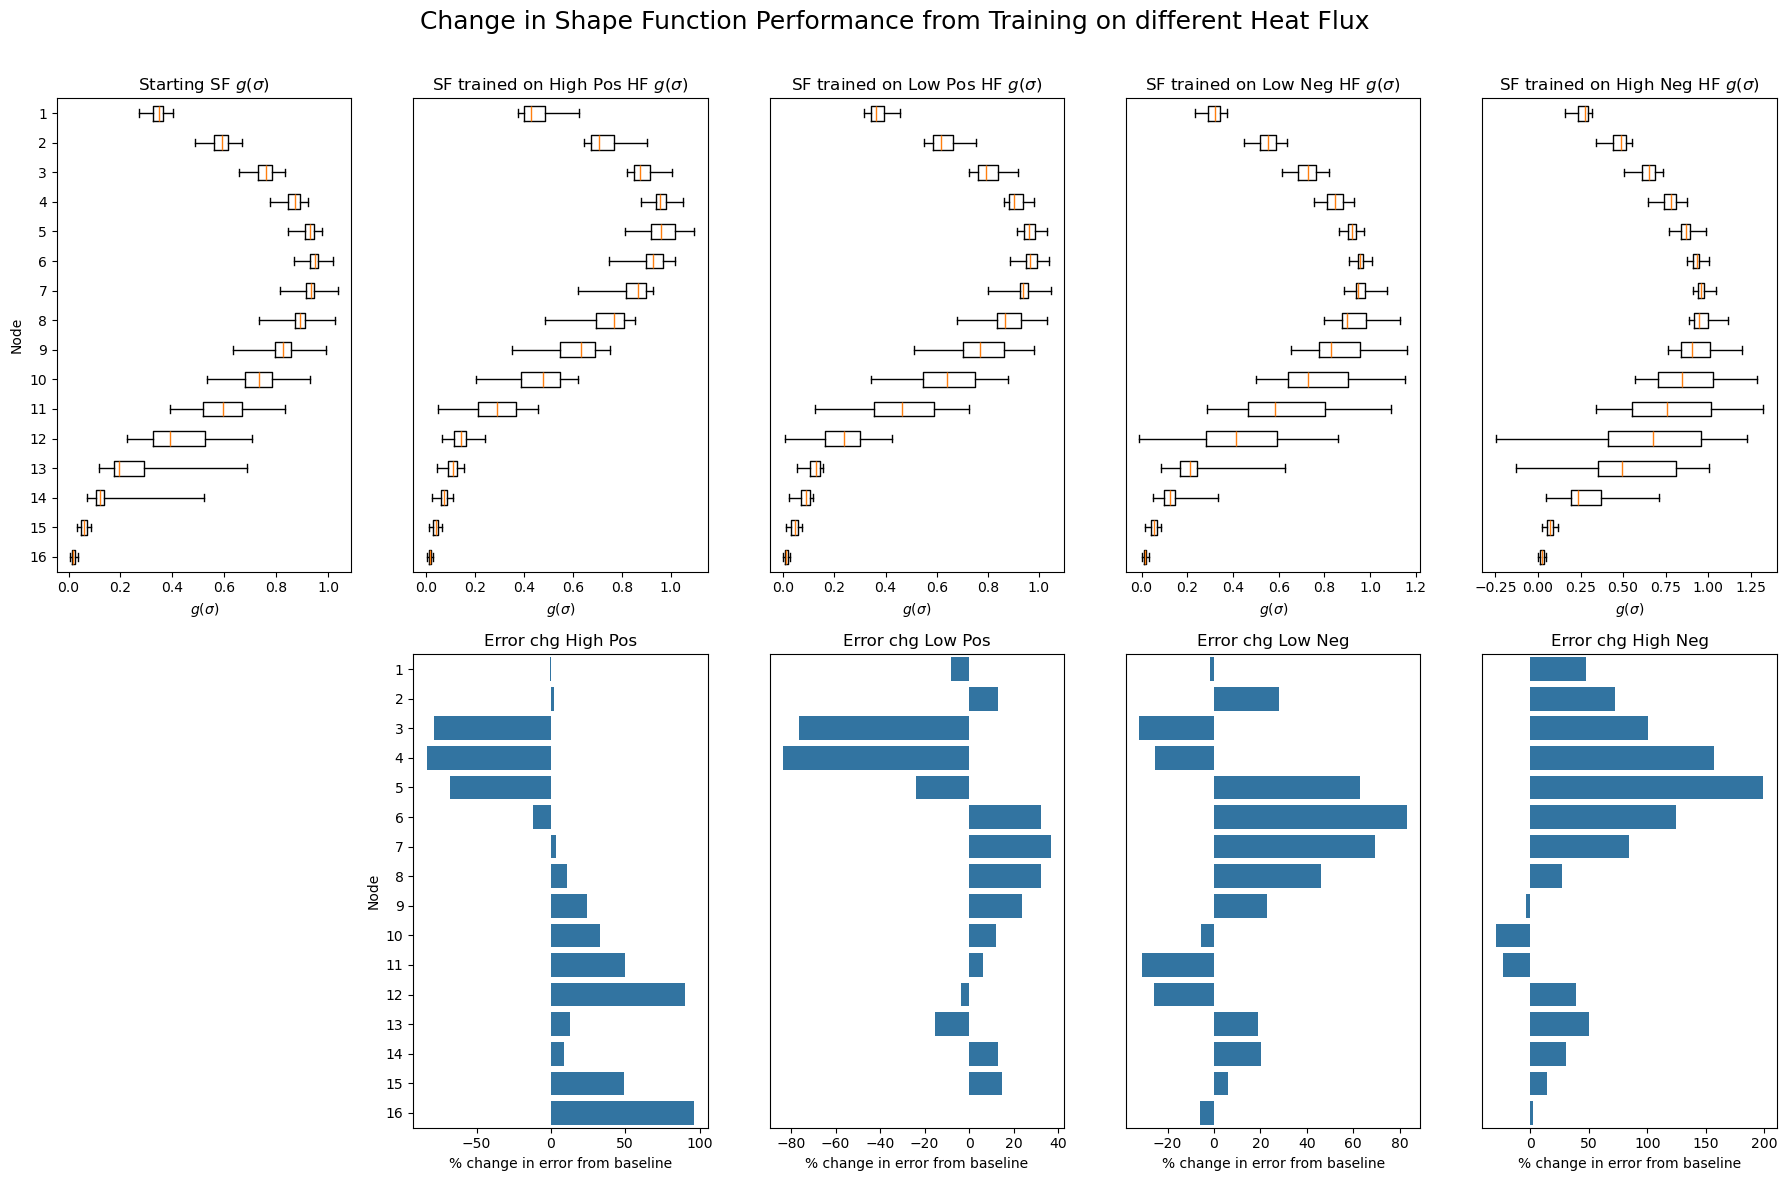

In [82]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 5, 1)
for i in range(16):
    plt.boxplot(kappa_mean[i] + np.exp(ytestcpu[:, i] * k_std[i] + k_mean[i]) - np.exp(yptestcpu[:, i] * k_std[i] + k_mean[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
#plt.yticks([])
plt.yticks(ind, ind_tick)
plt.ylabel('Node')
plt.title(r'Starting SF $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 5, 2)
for i in range(16):
    plt.boxplot(kappa_mean_hp[i] + np.exp(ytestcpu_hp[:, i] * k_std_hp[i] + k_mean_hp[i]) - np.exp(yptestcpu_hp[:, i] * k_std_hp[i] + k_mean_hp[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on High Pos HF $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 5, 3)
for i in range(16):
    plt.boxplot(kappa_mean_lp[i] + np.exp(ytestcpu_lp[:, i] * k_std_lp[i] + k_mean_lp[i]) - np.exp(yptestcpu_lp[:, i] * k_std_lp[i] + k_mean_lp[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Low Pos HF $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 5, 4)
for i in range(16):
    plt.boxplot(kappa_mean_ln[i] + np.exp(ytestcpu_ln[:, i] * k_std_ln[i] + k_mean_ln[i]) - np.exp(yptestcpu_ln[:, i] * k_std_ln[i] + k_mean_ln[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Low Neg HF $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 5, 5)
for i in range(16):
    plt.boxplot(kappa_mean_hn[i] + np.exp(ytestcpu_hn[:, i] * k_std_hn[i] + k_mean_hn[i]) - np.exp(yptestcpu_hn[:, i] * k_std_hn[i] + k_mean_hn[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on High Neg HF $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 5, 7)
sns.barplot(x=error_comp_hp, y=np.arange(len(error_comp_hp))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.ylabel('Node')
plt.title('Error chg High Pos')

plt.subplot(2, 5, 8)
sns.barplot(x=error_comp_lp, y=np.arange(len(error_comp_lp))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg Low Pos')

plt.subplot(2, 5, 9)
sns.barplot(x=error_comp_ln, y=np.arange(len(error_comp_ln))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg Low Neg')

plt.subplot(2, 5, 10)
sns.barplot(x=error_comp_hn, y=np.arange(len(error_comp_hn))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg High Neg')

plt.suptitle('Change in Shape Function Performance from Training on different Heat Flux',fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

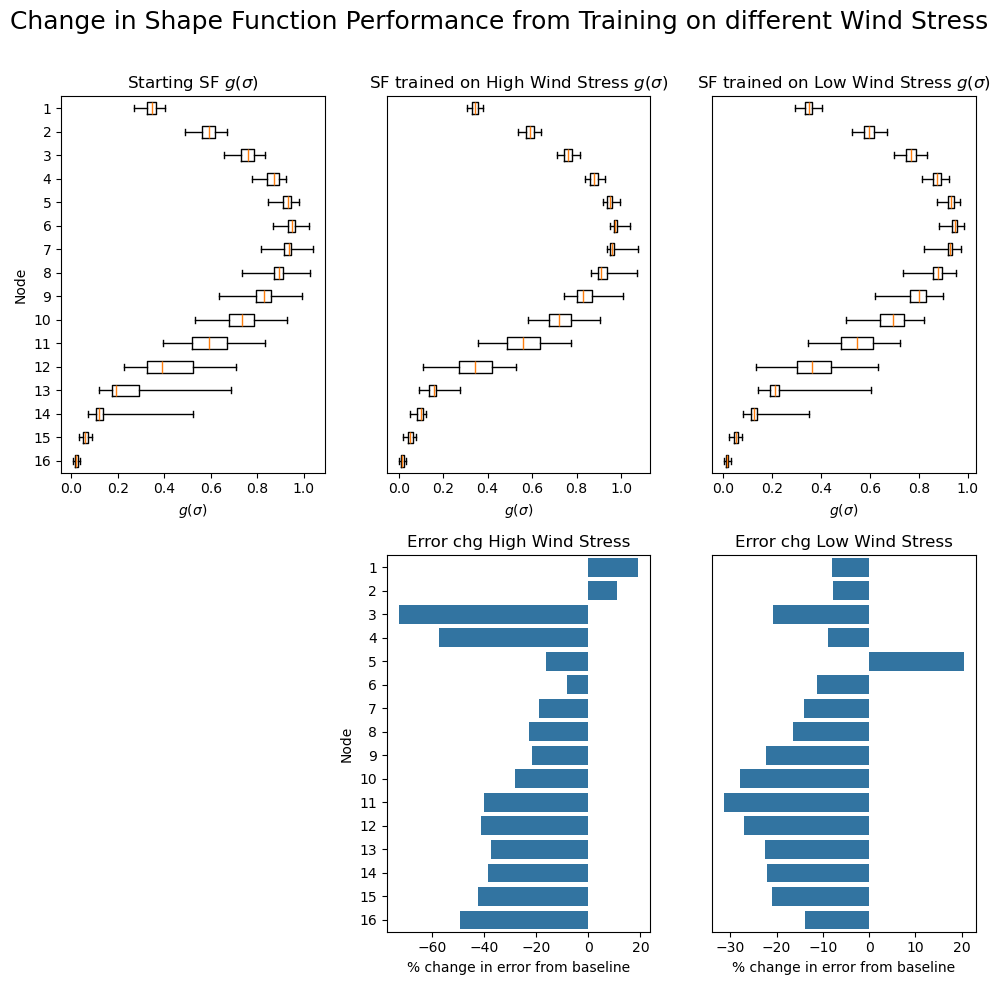

In [90]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 3, 1)
for i in range(16):
    plt.boxplot(kappa_mean[i] + np.exp(ytestcpu[:, i] * k_std[i] + k_mean[i]) - np.exp(yptestcpu[:, i] * k_std[i] + k_mean[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
#plt.yticks([])
plt.yticks(ind, ind_tick)
plt.ylabel('Node')
plt.title(r'Starting SF $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 3, 2)
for i in range(16):
    plt.boxplot(kappa_mean_hw[i] + np.exp(ytestcpu_hw[:, i] * k_std_hw[i] + k_mean_hw[i]) - np.exp(yptestcpu_hw[:, i] * k_std_hw[i] + k_mean_hw[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on High Wind Stress $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 3, 3)
for i in range(16):
    plt.boxplot(kappa_mean_lw[i] + np.exp(ytestcpu_lw[:, i] * k_std_lw[i] + k_mean_lw[i]) - np.exp(yptestcpu_lw[:, i] * k_std_lw[i] + k_mean_lw[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Low Wind Stress $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 3, 5)
sns.barplot(x=error_comp_hw, y=np.arange(len(error_comp_hw))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.ylabel('Node')
plt.title('Error chg High Wind Stress')

plt.subplot(2, 3, 6)
sns.barplot(x=error_comp_lw, y=np.arange(len(error_comp_lw))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg Low Wind Stress')

plt.suptitle('Change in Shape Function Performance from Training on different Wind Stress',fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### Split out further depending on Lat & Wind

#### Findings
- Performance for Tropics regions worse for high winds, mixed low winds
- Midlat & Polar saw improvement in many nodes
- Node 1 performance decreased for all but Tropics high winds

In [91]:
d_polar_hw = d_polar.where(d_polar.tx >= 1)
d_polar_lw = d_polar.where(d_polar.heat < 1)

d_midlat_hw = d_midlat.where(d_midlat.tx >= 1)
d_midlat_lw = d_midlat.where(d_midlat.heat < 1)

d_tropic_hw = d_tropic.where(d_tropic.heat >= 1) 
d_tropic_lw = d_tropic.where(d_tropic.heat < 1)


In [92]:
data_phw, x_phw, y_phw, stats_phw, k_mean_phw, k_std_phw  = vff.train_model(d_polar_hw, 'paper')
data_plw, x_plw, y_plw, stats_plw, k_mean_plw, k_std_plw  = vff.train_model(d_polar_lw, 'paper')

data_mhw, x_mhw, y_mhw, stats_mhw, k_mean_mhw, k_std_mhw  = vff.train_model(d_midlat_hw, 'paper')
data_mlw, x_mlw, y_mlw, stats_mlw, k_mean_mlw, k_std_mlw  = vff.train_model(d_midlat_lw, 'paper')

data_thw, x_thw, y_thw, stats_thw, k_mean_thw, k_std_thw  = vff.train_model(d_tropic_hw, 'paper')
data_tlw, x_tlw, y_tlw, stats_tlw, k_mean_tlw, k_std_tlw  = vff.train_model(d_tropic_lw, 'paper')

started paper model
started paper model
started paper model
started paper model
started paper model
started paper model


In [93]:
x_phw, x_test_phw, y_phw, y_test_phw = validation_new(x_phw, y_phw)
x_plw, x_test_plw, y_plw, y_test_plw = validation_new(x_plw, y_plw)

x_mhw, x_test_mhw, y_mhw, y_test_mhw = validation_new(x_mhw, y_mhw)
x_mlw, x_test_mlw, y_mlw, y_test_mlw = validation_new(x_mlw, y_mlw)

x_thw, x_test_thw, y_thw, y_test_thw = validation_new(x_thw, y_thw)
x_tlw, x_test_tlw, y_tlw, y_test_tlw = validation_new(x_tlw, y_tlw)

In [94]:
epochs, k_points1, lr1=3000, 12, 1e-04

k_mean_phwc=torch.tensor(k_mean_phw).float().to(device)
k_std_phwc=torch.tensor(k_std_phw).float().to(device)

model_phw, loss_array_phw = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_phw, y_phw,x_test_phw,y_test_phw,model,torch.tensor(kmask).float().to(device), k_mean_phwc, k_std_phwc)

k_mean_plwc=torch.tensor(k_mean_plw).float().to(device)
k_std_plwc=torch.tensor(k_std_plw).float().to(device)

model_plw, loss_array_plw = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_plw, y_plw,x_test_plw,y_test_plw,model,torch.tensor(kmask).float().to(device), k_mean_plwc, k_std_plwc)

k_mean_mhwc=torch.tensor(k_mean_mhw).float().to(device)
k_std_mhwc=torch.tensor(k_std_mhw).float().to(device)
model_mhw, loss_array_mhw = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_mhw, y_mhw,x_test_mhw,y_test_mhw,model,torch.tensor(kmask).float().to(device), k_mean_mhwc, k_std_mhwc)

k_mean_mlwc=torch.tensor(k_mean_mlw).float().to(device)
k_std_mlwc=torch.tensor(k_std_mlw).float().to(device)
model_mlw, loss_array_mlw = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_mlw, y_mlw,x_test_mlw,y_test_mlw,model,torch.tensor(kmask).float().to(device), k_mean_mlwc, k_std_mlwc)

k_mean_thwc=torch.tensor(k_mean_thw).float().to(device)
k_std_thwc=torch.tensor(k_std_thw).float().to(device)
model_thw, loss_array_thw = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_thw, y_thw,x_test_thw,y_test_thw,model,torch.tensor(kmask).float().to(device), k_mean_thwc, k_std_thwc)

k_mean_tlwc=torch.tensor(k_mean_tlw).float().to(device)
k_std_tlwc=torch.tensor(k_std_tlw).float().to(device)
model_tlw, loss_array_tlw = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_tlw, y_tlw,x_test_tlw,y_test_tlw,model,torch.tensor(kmask).float().to(device), k_mean_tlwc, k_std_tlwc)

Training Progress:  18%|█▊        | 555/3000 [00:01<00:06, 359.33epoch/s, patience_count=19, train_loss=0.0216, valid_loss=0.022] 



Early stopping at epoch 555. Validation loss has not improved for 20 epochs.


Training Progress:  20%|██        | 603/3000 [00:02<00:11, 201.38epoch/s, patience_count=19, train_loss=0.0323, valid_loss=0.0322]



Early stopping at epoch 603. Validation loss has not improved for 20 epochs.


Training Progress:  19%|█▊        | 556/3000 [00:01<00:08, 292.20epoch/s, patience_count=19, train_loss=0.0225, valid_loss=0.0223]



Early stopping at epoch 556. Validation loss has not improved for 20 epochs.


Training Progress:  22%|██▏       | 663/3000 [00:05<00:18, 123.45epoch/s, patience_count=19, train_loss=0.0312, valid_loss=0.0312]



Early stopping at epoch 663. Validation loss has not improved for 20 epochs.


Training Progress:  54%|█████▎    | 1612/3000 [00:07<00:06, 207.06epoch/s, patience_count=19, train_loss=0.0434, valid_loss=0.0434]



Early stopping at epoch 1612. Validation loss has not improved for 20 epochs.


Training Progress:  32%|███▏      | 946/3000 [00:04<00:10, 193.24epoch/s, patience_count=19, train_loss=0.0566, valid_loss=0.0563]


Early stopping at epoch 946. Validation loss has not improved for 20 epochs.


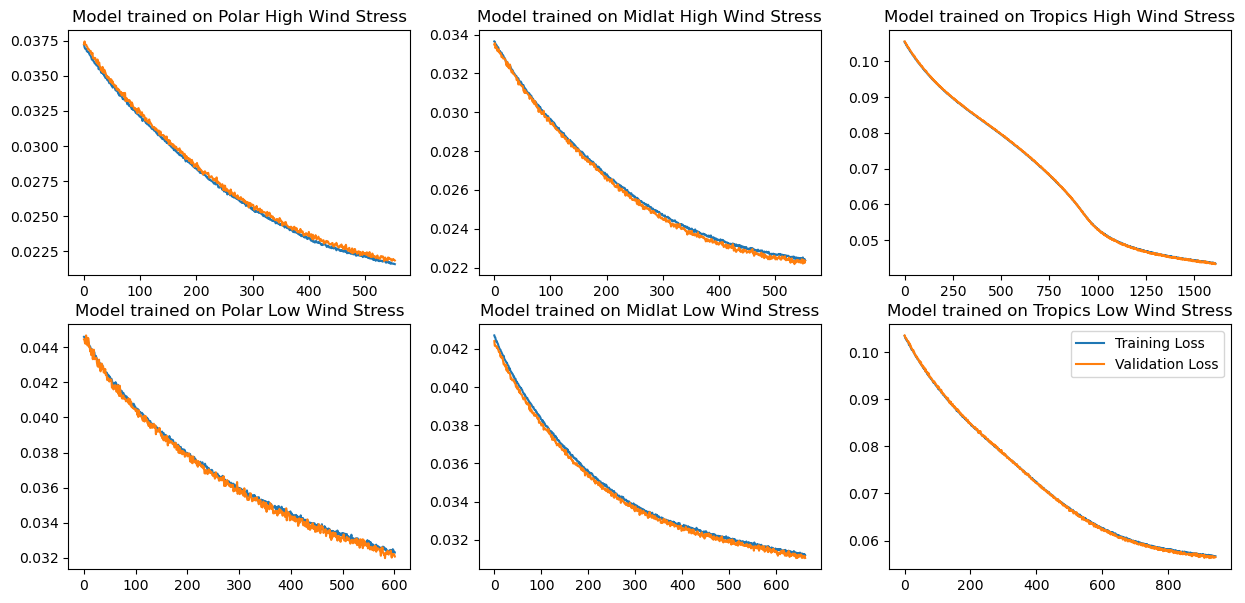

In [101]:
fig, axes = plt.subplots(figsize=(15, 7), ncols = 3, nrows = 2)
axes[0,0].plot(loss_array_phw[:, 0], loss_array_phw[:, 1], label="Training Loss")
axes[0,0].plot(loss_array_phw[:, 0], loss_array_phw[:, 2], label="Validation Loss")
axes[0,0].set_title("Model trained on Polar High Wind Stress")
axes[0,1].plot(loss_array_mhw[:, 0], loss_array_mhw[:, 1], label="Training Loss")
axes[0,1].plot(loss_array_mhw[:, 0], loss_array_mhw[:, 2], label="Validation Loss")
axes[0,1].set_title("Model trained on Midlat High Wind Stress")
axes[0,2].plot(loss_array_thw[:, 0], loss_array_thw[:, 1], label="Training Loss")
axes[0,2].plot(loss_array_thw[:, 0], loss_array_thw[:, 2], label="Validation Loss")
axes[0,2].set_title("Model trained on Tropics High Wind Stress")
axes[1,0].plot(loss_array_plw[:, 0], loss_array_plw[:, 1], label="Training Loss")
axes[1,0].plot(loss_array_plw[:, 0], loss_array_plw[:, 2], label="Validation Loss")
axes[1,0].set_title("Model trained on Polar Low Wind Stress")
axes[1,1].plot(loss_array_mlw[:, 0], loss_array_mlw[:, 1], label="Training Loss")
axes[1,1].plot(loss_array_mlw[:, 0], loss_array_mlw[:, 2], label="Validation Loss")
axes[1,1].set_title("Model trained on Midlat Low Wind Stress")
axes[1,2].plot(loss_array_tlw[:, 0], loss_array_tlw[:, 1], label="Training Loss")
axes[1,2].plot(loss_array_tlw[:, 0], loss_array_tlw[:, 2], label="Validation Loss")
axes[1,2].set_title("Model trained on Tropics Low Wind Stress")
plt.legend()
plt.savefig('Training_Validation_loss_new_var.png')
plt.show()

In [102]:
yerr_phw, kappa_mean_phw, ytestcpu_phw, yptestcpu_phw = vff.return_model_error(model_phw,x_phw,x_test_phw,y_phw,y_test_phw,k_mean_phw,k_std_phw)
yerr_plw, kappa_mean_plw, ytestcpu_plw, yptestcpu_plw = vff.return_model_error(model_plw,x_plw,x_test_plw,y_plw,y_test_plw,k_mean_plw,k_std_plw)

yerr_mhw, kappa_mean_mhw, ytestcpu_mhw, yptestcpu_mhw = vff.return_model_error(model_mhw,x_mhw,x_test_mhw,y_mhw,y_test_mhw,k_mean_mhw,k_std_mhw)
yerr_mlw, kappa_mean_mlw, ytestcpu_mlw, yptestcpu_mlw = vff.return_model_error(model_mlw,x_mlw,x_test_mlw,y_mlw,y_test_mlw,k_mean_mlw,k_std_mlw)

yerr_thw, kappa_mean_thw, ytestcpu_thw, yptestcpu_thw = vff.return_model_error(model_thw,x_thw,x_test_thw,y_thw,y_test_thw,k_mean_thw,k_std_thw)
yerr_tlw, kappa_mean_tlw, ytestcpu_tlw, yptestcpu_tlw = vff.return_model_error(model_tlw,x_tlw,x_test_tlw,y_tlw,y_test_tlw,k_mean_tlw,k_std_tlw)

error_comp_phw = ((yerr_phw - yerr)/yerr)*100
error_comp_plw = ((yerr_plw - yerr)/yerr)*100

error_comp_mhw = ((yerr_mhw - yerr)/yerr)*100
error_comp_mlw = ((yerr_mlw - yerr)/yerr)*100

error_comp_thw = ((yerr_thw - yerr)/yerr)*100
error_comp_tlw = ((yerr_tlw - yerr)/yerr)*100

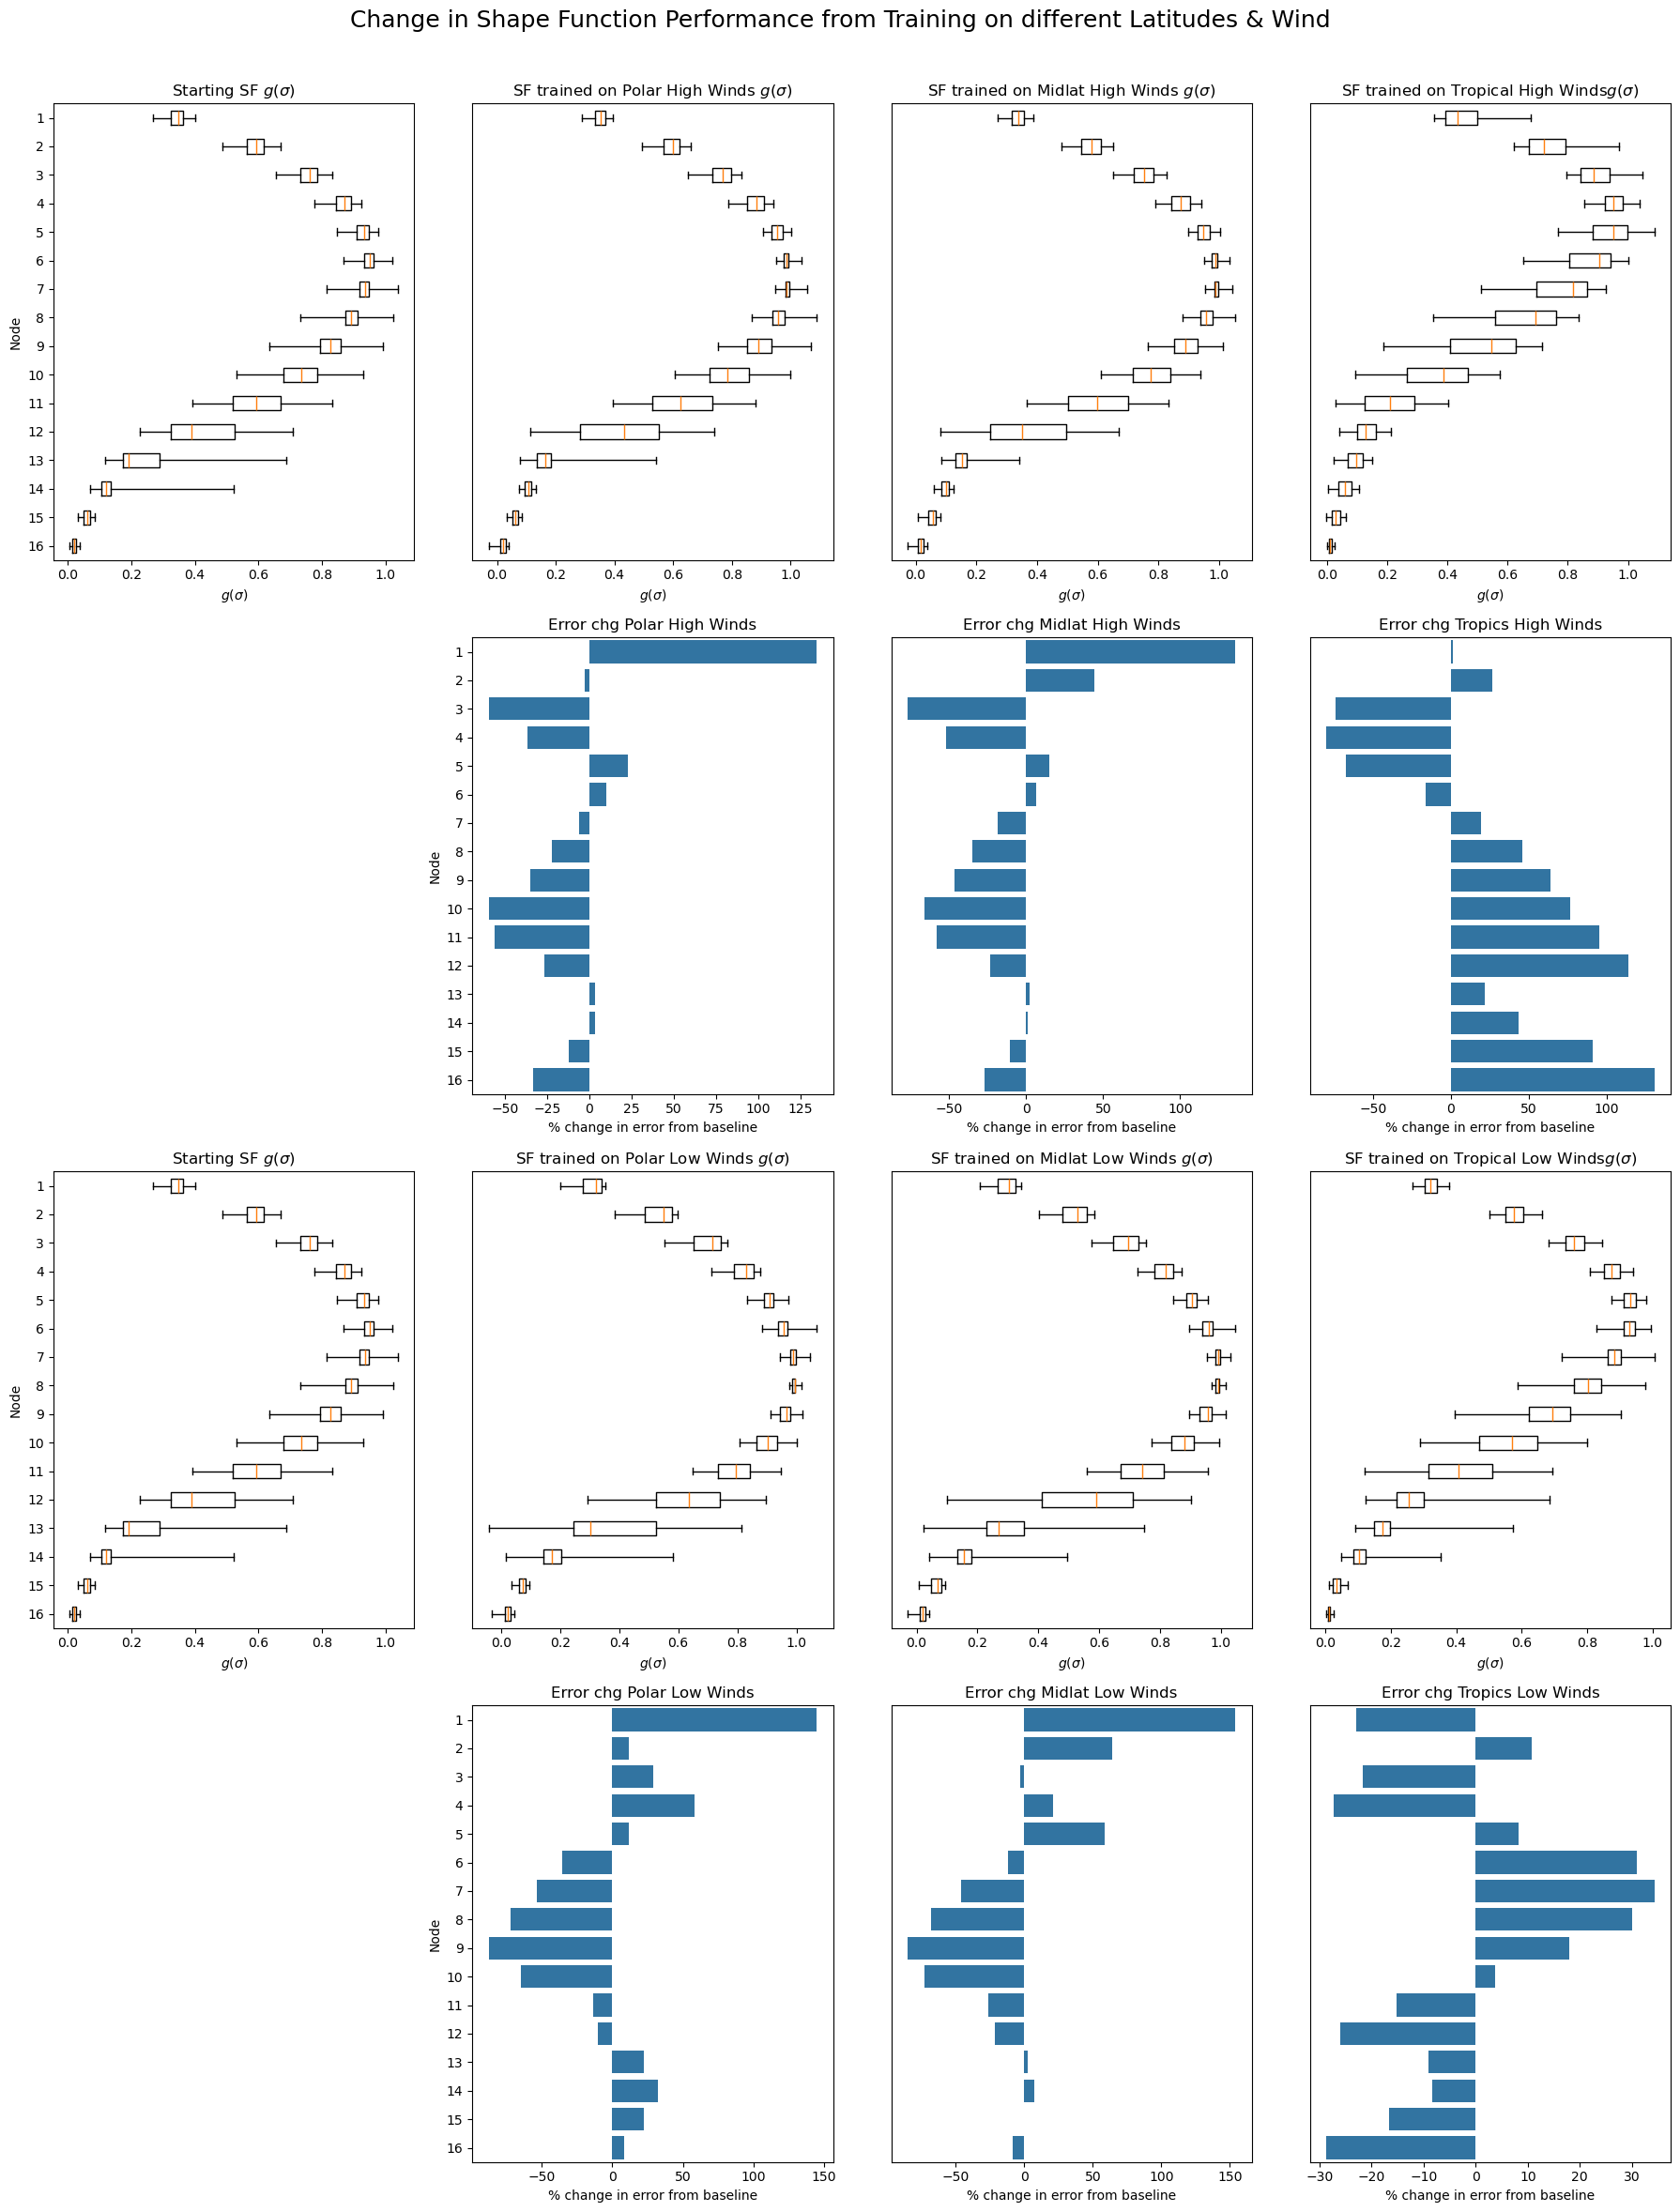

In [104]:
plt.figure(figsize=(18, 24))

plt.subplot(4, 4, 1)
for i in range(16):
    plt.boxplot(kappa_mean[i] + np.exp(ytestcpu[:, i] * k_std[i] + k_mean[i]) - np.exp(yptestcpu[:, i] * k_std[i] + k_mean[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
#plt.yticks([])
plt.yticks(ind, ind_tick)
plt.ylabel('Node')
plt.title(r'Starting SF $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(4, 4, 2)
for i in range(16):
    plt.boxplot(kappa_mean_phw[i] + np.exp(ytestcpu_phw[:, i] * k_std_phw[i] + k_mean_phw[i]) - np.exp(yptestcpu_phw[:, i] * k_std_phw[i] + k_mean_phw[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Polar High Winds $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(4, 4, 3)
for i in range(16):
    plt.boxplot(kappa_mean_mhw[i] + np.exp(ytestcpu_mhw[:, i] * k_std_mhw[i] + k_mean_mhw[i]) - np.exp(yptestcpu_mhw[:, i] * k_std_mhw[i] + k_mean_mhw[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Midlat High Winds $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(4, 4, 4)
for i in range(16):
    plt.boxplot(kappa_mean_thw[i] + np.exp(ytestcpu_thw[:, i] * k_std_thw[i] + k_mean_thw[i]) - np.exp(yptestcpu_thw[:, i] * k_std_thw[i] + k_mean_thw[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Tropical High Winds$g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(4, 4, 6)
sns.barplot(x=error_comp_phw, y=np.arange(len(error_comp_phw))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.ylabel('Node')
plt.title('Error chg Polar High Winds')

plt.subplot(4, 4, 7)
sns.barplot(x=error_comp_mhw, y=np.arange(len(error_comp_mhw))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg Midlat High Winds')

plt.subplot(4, 4, 8)
sns.barplot(x=error_comp_thw, y=np.arange(len(error_comp_thw))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg Tropics High Winds')

plt.subplot(4, 4, 9)
for i in range(16):
    plt.boxplot(kappa_mean[i] + np.exp(ytestcpu[:, i] * k_std[i] + k_mean[i]) - np.exp(yptestcpu[:, i] * k_std[i] + k_mean[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
#plt.yticks([])
plt.yticks(ind, ind_tick)
plt.ylabel('Node')
plt.title(r'Starting SF $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(4, 4, 10)
for i in range(16):
    plt.boxplot(kappa_mean_plw[i] + np.exp(ytestcpu_plw[:, i] * k_std_plw[i] + k_mean_plw[i]) - np.exp(yptestcpu_plw[:, i] * k_std_plw[i] + k_mean_plw[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Polar Low Winds $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(4, 4, 11)
for i in range(16):
    plt.boxplot(kappa_mean_mlw[i] + np.exp(ytestcpu_mlw[:, i] * k_std_mlw[i] + k_mean_mlw[i]) - np.exp(yptestcpu_mlw[:, i] * k_std_mlw[i] + k_mean_mlw[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Midlat Low Winds $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(4, 4, 12)
for i in range(16):
    plt.boxplot(kappa_mean_tlw[i] + np.exp(ytestcpu_tlw[:, i] * k_std_tlw[i] + k_mean_tlw[i]) - np.exp(yptestcpu_tlw[:, i] * k_std_tlw[i] + k_mean_tlw[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Tropical Low Winds$g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(4, 4, 14)
sns.barplot(x=error_comp_plw, y=np.arange(len(error_comp_plw))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.ylabel('Node')
plt.title('Error chg Polar Low Winds')

plt.subplot(4, 4, 15)
sns.barplot(x=error_comp_mlw, y=np.arange(len(error_comp_mlw))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg Midlat Low Winds')

plt.subplot(4, 4, 16)
sns.barplot(x=error_comp_tlw, y=np.arange(len(error_comp_tlw))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg Tropics Low Winds')

plt.suptitle('Change in Shape Function Performance from Training on different Latitudes & Wind',fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()